In [2]:
import pandas as pd
import quantstats as qs
import vectorbt as vbt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

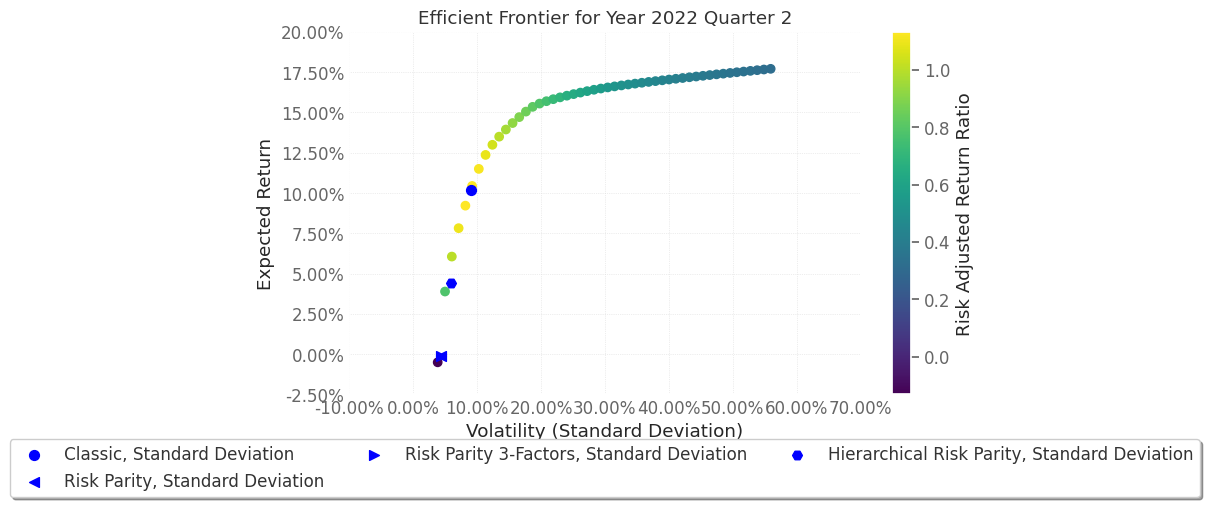

In [3]:
from plotting import plot_efficient_frontier

plot_efficient_frontier(2022, 2)

## Risk methods

In [4]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from typing import Tuple, List
from scipy.stats import norm
import pandas_market_calendars as mcal
import riskfolio as rp


# Calculate VaR for multiple periods and confidence levels
def calculate_historical_var(
    portfolio_value: int,
    confidence_levels: List[float],
    log_returns: pd.DataFrame,
    weights: np.ndarray,
    start_date: datetime,
    days: int = 365,
    type_of_var: str = "historic",
) -> dict:
    new_start_date = start_date - timedelta(days=days)
    trading_days = trading_days_between_dates(new_start_date, start_date)
    simple_returns = np.exp(log_returns) - 1
    port_returns = simple_returns.tail(trading_days).dot(weights)

    var_results = {}
    for conf in confidence_levels:
        if type_of_var == "Conditional":
            var_value = rp.RiskFunctions.CVaR_Hist(port_returns, alpha=1 - conf)
        elif type_of_var == "Entropic":
            var_value, z = rp.RiskFunctions.EVaR_Hist(port_returns, alpha=1 - conf)
        else:
            var_value = rp.RiskFunctions.VaR_Hist(port_returns, alpha=1 - conf)

        var_results[conf] = var_value * portfolio_value

    return var_results


# Calculate VaR using Monte Carlo simulation
def monte_carlo_var(
    log_returns, portfolio_value, weights, confidence_levels, no_of_simulations
):
    # Convert log returns to simple returns
    simple_returns = np.exp(log_returns) - 1

    # Calculate mean and standard deviation of portfolio returns
    port_returns = simple_returns.dot(weights)
    mean = port_returns.mean()
    std_dev = port_returns.std()

    # Simulate future returns using geometric Brownian motion
    np.random.seed(42)
    simulated_returns = np.random.normal(
        loc=mean, scale=std_dev, size=(no_of_simulations)
    )

    # Calculate simulated future portfolio values
    simulated_end_portfolio_values = portfolio_value * np.exp(simulated_returns)

    # Calculate the VaR at the desired confidence level
    var_results = {}
    for conf in confidence_levels:
        var_value = np.percentile(simulated_end_portfolio_values, (1 - conf) * 100)
        var_results[conf] = abs(var_value - portfolio_value)

    return var_results, simulated_end_portfolio_values


def trading_days_between_dates(
    start_date: datetime, end_date: datetime, exchange: str = "XSES"
) -> int:
    cal = mcal.get_calendar(exchange)
    trading_days = cal.schedule(start_date=start_date, end_date=end_date)
    return len(trading_days)

In [5]:
from risk_measures import rm_names, MODELS

MODELS = [
    "Classic",
    "Classic 3-Factors",
]

rm_names = [
    "Standard Deviation",
    "Mean Absolute Deviation",
]


def calculate_portfolio_vars(
    year, quarter, portfolio_value, confidence_levels, days_to_simulate: int = 252
):
    portfolios = {}
    for model in MODELS:
        if model in ["Monte Carlo"]:
            risk_measures = ["Standard Deviation"]
        elif "Risk Parity" in model and "Hierarchical" not in model:
            excluded = [
                "Worst Realization",
                "Average Drawdown",
                "Max Drawdown",
                "Range",
            ]
            risk_measures = [risk for risk in rm_names if risk not in excluded]
        else:
            risk_measures = rm_names

        for risk_measure in risk_measures:
            portfolios[model, risk_measure] = pd.read_parquet(
                f"../data/studying_models/port_weights/{model}_{risk_measure}_{year}_Q{quarter}.parquet"
            )

    returns = pd.read_parquet(
        f"../data/studying_models/input_returns/{year}_Q{quarter}.parquet"
    )

    results = {}

    # Start date for historical VaR calculation
    start_date = returns.index.max().date()

    for (model, risk_measure), weights in portfolios.items():
        # Adjust weights and calculate yearly mean returns and volatilities
        weights = weights.squeeze()
        weights = weights.reindex(returns.columns, fill_value=0.0)

        types = ["Historic", "Conditional", "Entropic"]
        years = [1, 2, 3]
        # VaR Calculations
        results[model, risk_measure, "Monte Carlo VaR"], simulated_portfolio_val = (
            monte_carlo_var(returns, portfolio_value, weights, confidence_levels, 10000)
        )

        for type_of_var in types:
            for year in years:
                results[model, risk_measure, f"{type_of_var} VaR {year}Yr"] = (
                    calculate_historical_var(
                        portfolio_value,
                        confidence_levels,
                        returns,
                        weights,
                        start_date,
                        365 * year,
                        type_of_var,
                    )
                )

    return pd.DataFrame(results), simulated_portfolio_val

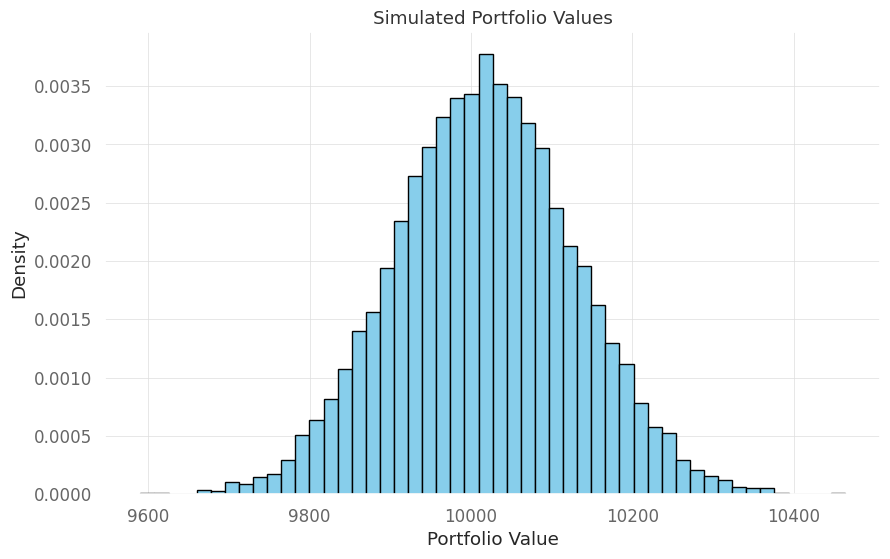

In [6]:
results, simulated_portfolio_val = calculate_portfolio_vars(
    2022, 3, 10000, [0.93, 0.95, 0.97, 0.99], 252
)

import matplotlib.pyplot as plt

# Plot the simulated portfolio values
plt.figure(figsize=(10, 6))
plt.hist(
    simulated_portfolio_val, bins=50, color="skyblue", edgecolor="black", density=True
)
plt.xlabel("Portfolio Value")
plt.ylabel("Density")
plt.title("Simulated Portfolio Values")
plt.show()

In [7]:
results

Classic                                                     \
     Standard Deviation                                                      
        Monte Carlo VaR Historic VaR 1Yr Historic VaR 2Yr Historic VaR 3Yr   
0.93         144.542521       157.891918       126.589486       128.274150   
0.95         163.034544       171.493807       147.743806       157.891918   
0.97         188.449667       215.087101       172.860831       204.597839   
0.99         234.786307       334.326695       283.367569       334.326695   

                                                                  \
                                                                   
     Conditional VaR 1Yr Conditional VaR 2Yr Conditional VaR 3Yr   
0.93          232.343484          203.952495          226.107517   
0.95          260.007590          231.814797          260.913695   
0.97          307.383562          276.871764          320.435064   
0.99          403.318554          369.272843          467.526314   

                                                         ...  \
                                                         ...   
     Entropic VaR 1Yr Entropic VaR 2Yr Entropic VaR 3Yr  ...   
0.93       334.334755       304.978659       387.645817  ...   
0.95       359.764181       329.768528       420.793421  ...   
0.97       395.690238       365.051463       468.271322  ...   
0.99       462.160618       431.962243       559.248551  ...   

           Classic 3-Factors                                    \
     Mean Absolute Deviation                                     
             Monte Carlo VaR Historic VaR 1Yr Historic VaR 2Yr   
0.93              146.599555       155.544458       137.948971   
0.95              165.261887       174.654621       149.503930   
0.97              190.910541       215.906958       179.673048   
0.99              237.671340       340.195691       280.458441   

                                                               \
                                                                
     Historic VaR 3Yr Conditional VaR 1Yr Conditional VaR 2Yr   
0.93       137.948971          237.068489          208.496123   
0.95       149.517931          266.348189          235.196576   
0.97       208.777413          314.170074          283.316151   
0.99       340.195691          417.246771          383.569481   

                                                                             
                                                                             
     Conditional VaR 3Yr Entropic VaR 1Yr Entropic VaR 2Yr Entropic VaR 3Yr  
0.93          227.386271       351.341832       319.306617       387.593168  
0.95          261.398406       378.443014       345.674109       420.609236  
0.97          322.552718       416.859681       383.330661       467.893715  
0.99          469.379769       488.527219       455.282666       558.526319  

[4 rows x 40 columns]

In [8]:
def get_equities_data() -> pd.DataFrame:
    equities = pd.read_parquet(
        "../data/obtain_tickers/equities.parquet", columns=["Code"]
    )

    data = {}
    for code in equities["Code"]:
        try:
            file_name = f"stock_{code[:3]}" if code != "^STI" else "STI"
            df = pd.read_parquet(
                f"../data/obtain_data/{file_name}.parquet", columns=["Date", "Close"]
            )
            df.rename(columns={"Close": code}, inplace=True)
            data[code] = df
        except Exception as e:
            print(f"Error in {code}: {e}")

    equities_data = pd.concat(data.values(), axis=1)
    equities_data.index = pd.to_datetime(equities_data.index)
    return equities_data


def calculate_profit_and_loss(
    data: pd.DataFrame, benchmark: pd.DataFrame, weights: pd.DataFrame
) -> Tuple[float, float, float]:
    benchmark_return = calculate_total_return(benchmark)
    portfolio_return = calculate_total_return(data, weights)
    print(f"Portfolio return: {portfolio_return}\nBenchmark return: {benchmark_return}")
    profit_and_loss = portfolio_return - benchmark_return
    return portfolio_return, benchmark_return, profit_and_loss


def calculate_total_return(data: pd.DataFrame, weights: pd.DataFrame = None) -> float:
    if weights is not None:
        total_return = 0
        for ticker, row in weights.iterrows():
            weight = row["weights"]
            if ticker in data.columns:
                stock_df = data[ticker].dropna()
                if not stock_df.empty:
                    start_price = stock_df.iloc[0]
                    end_price = stock_df.iloc[-1]
                    total_return += ((end_price - start_price) / start_price) * weight
                    print(
                        f"Calculating return for {ticker}, weight: {weight}, return: {total_return}"
                    )
                else:
                    print(f"No data for {ticker}")
        total_return *= 100
    else:
        start_price = data.iloc[0]
        end_price = data.iloc[-1]
        total_return = ((end_price - start_price) / start_price) * 100
    return total_return


def calculate_stock_return(df):
    start_price = df.iloc[0, 0]
    end_price = df.iloc[-1, 0]
    return (end_price - start_price) / start_price * 100


def get_asset_classes() -> pd.DataFrame:
    asset_classes = pd.read_parquet(
        "../data/obtain_tickers/equities.parquet",
        columns=["Code", "Company Name", "Sector"],
    )
    return asset_classes


def get_stock_and_sector_returns(
    data: pd.DataFrame, tickers: list, crisis_name: str, portfolio_value: int
) -> pd.DataFrame:
    asset_classes = get_asset_classes()

    result_list = []

    for ticker in tickers:
        name = asset_classes.loc[
            asset_classes["Code"] == ticker, "Company Name"
        ].values[0]
        sector = asset_classes.loc[asset_classes["Code"] == ticker, "Sector"].values[0]

        stock_df = data[[ticker]].dropna()
        if stock_df.empty:
            print(f"No data for {ticker}")
            continue

        stock_return = calculate_stock_return(stock_df)
        crisis_name_intials = "".join([name[0] for name in crisis_name.split(" ")])
        result_list.append(
            {
                "Ticker": ticker,
                "Name": name,
                "Sector": sector,
                f"{crisis_name} Returns %": stock_return,
                f"{crisis_name_intials} Returns $": stock_return
                * portfolio_value
                / 100,
            }
        )

    result_df = pd.DataFrame(result_list)
    grouped_df = result_df.set_index(["Sector", "Name", "Ticker"])

    return grouped_df

In [9]:
financial_crisis = {
    "European Debt Crisis": ("2011-07-01", "2012-06-30"),
    "Chinese Stock Market Crash": ("2015-06-12", "2015-08-31"),
    "US-China Trade War Impact": ("2018-06-15", "2019-12-13"),
    "2019 Singapore Economic Slowdown": ("2019-01-01", "2019-12-31"),
    "COVID-19 Impact": ("2020-02-20", "2020-03-23"),
}

MODELS = [
    "Classic",
]

rm_names = [
    "Standard Deviation",
    "Mean Absolute Deviation",
]

scenario_summary_data = []
sector_returns = []
portfolio_value = 10000
model = MODELS[0]
risk_measure = rm_names[0]
equities_data = get_equities_data()
sti_data = equities_data["^STI"].ffill(limit=5).bfill(limit=5)

for crisis_name, (start_date, end_date) in financial_crisis.items():
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")

    equities_data_crisis = equities_data.loc[start_date:end_date]
    sti_data_crisis = sti_data.loc[start_date:end_date]
    weights_org = pd.read_parquet(
        f"../data/studying_models/port_weights/{model}_{risk_measure}_{2022}_Q{3}.parquet"
    )

    portfolio_return, benchmark_return, profit_and_loss = calculate_profit_and_loss(
        equities_data_crisis, sti_data_crisis, weights_org
    )

    stock_and_sector_returns = get_stock_and_sector_returns(
        equities_data_crisis, weights_org.index.tolist(), crisis_name, portfolio_value
    )
    scenario_summary_data.append(
        {
            "Scenario": crisis_name,
            "P/L ($)": profit_and_loss * portfolio_value / 100,
            "P/L (%)": profit_and_loss,
            "P. Return ($)": portfolio_return * portfolio_value / 100,
            "P. Return (%)": portfolio_return,
            "B. Return ($)": benchmark_return * portfolio_value / 100,
            "B. Return (%)": benchmark_return,
        }
    )
    sector_returns.append(stock_and_sector_returns)

scenario_summary_df = pd.DataFrame(scenario_summary_data)
scenario_summary_df = (
    scenario_summary_df.sort_values(by=scenario_summary_df.columns[3], ascending=False)
    .reset_index(drop=True)
    .set_index("Scenario")
)

combined_sector_returns = pd.concat(sector_returns, axis=1)

Calculating return for AWX.SI, weight: 0.04499482488250001, return: 0.05061968148277479
Calculating return for P9D.SI, weight: 0.008302372958965909, return: 0.05578061549467059
Calculating return for D03.SI, weight: 0.024164217177751305, return: 0.05604616231701268
No data for RE4.SI
No data for JLB.SI
No data for AIY.SI
Calculating return for 1J4.SI, weight: 0.04844616906727472, return: 0.058814524416229065
No data for 1D0.SI
No data for 41O.SI
No data for OYY.SI
Calculating return for DM0.SI, weight: 0.04086006459683611, return: 0.06732703755678741
Calculating return for S56.SI, weight: 0.0889251514852218, return: 0.04532976720627431
Calculating return for U96.SI, weight: 0.08825133418418409, return: 0.04637418065613003
Calculating return for OV8.SI, weight: 0.04148282783221497, return: 0.054553896080327714
Calculating return for AGS.SI, weight: 0.1537999545378237, return: 0.058274862185790206
No data for 8K7.SI
Calculating return for BDR.SI, weight: 0.011232279938915363, return: 0.0

In [10]:
scenario_summary_df

P/L ($)    P/L (%)  P. Return ($)  \
Scenario                                                                  
2019 Singapore Economic Slowdown   886.251064   8.862511    1388.310749   
European Debt Crisis              1305.374469  13.053745     475.303658   
US-China Trade War Impact         -122.318006  -1.223180    -453.210501   
Chinese Stock Market Crash         230.812667   2.308127   -1058.482155   
COVID-19 Impact                    336.888716   3.368887   -2680.605912   

                                  P. Return (%)  B. Return ($)  B. Return (%)  
Scenario                                                                       
2019 Singapore Economic Slowdown      13.883107     502.059685       5.020597  
European Debt Crisis                   4.753037    -830.070811      -8.300708  
US-China Trade War Impact             -4.532105    -330.892495      -3.308925  
Chinese Stock Market Crash           -10.584822   -1289.294821     -12.892948  
COVID-19 Impact                      -26.806059   -3017.494628     -30.174946

In [11]:
combined_sector_returns

European Debt Crisis Returns %  \
Sector             Name             Ticker                                   
Technology         AEM SGD          AWX.SI                      112.501119   
Industrials        Civmec           P9D.SI                       62.162156   
Consumer Defensive Del Monte Pac    D03.SI                        1.098926   
Industrials        JEP              1J4.SI                        5.714305   
Consumer Cyclical  PSC Corporation  DM0.SI                       20.833333   
Industrials        SamuderaShipping S56.SI                      -24.736838   
                   Sembcorp Ind     U96.SI                        1.183453   
Consumer Defensive Sheng Siong      OV8.SI                       19.718317   
Consumer Cyclical  TheHourGlass     AGS.SI                        2.419354   
Technology         Willas-Array     BDR.SI                       -6.875001   
Healthcare         Medtecs Intl     546.SI                      -31.249999   
Energy             Geo Energy Res   RE4.SI                             NaN   
Technology         IFAST            AIY.SI                             NaN   
Real Estate        LHN              41O.SI                             NaN   
Healthcare         UGHealthcare     8K7.SI                             NaN   
Technology         Grand Venture    JLB.SI                             NaN   
Consumer Cyclical  Kimly            1D0.SI                             NaN   
Real Estate        PropNex          OYY.SI                             NaN   

                                            EDC Returns $  \
Sector             Name             Ticker                  
Technology         AEM SGD          AWX.SI   11250.111900   
Industrials        Civmec           P9D.SI    6216.215578   
Consumer Defensive Del Monte Pac    D03.SI     109.892582   
Industrials        JEP              1J4.SI     571.430549   
Consumer Cyclical  PSC Corporation  DM0.SI    2083.333256   
Industrials        SamuderaShipping S56.SI   -2473.683765   
                   Sembcorp Ind     U96.SI     118.345344   
Consumer Defensive Sheng Siong      OV8.SI    1971.831684   
Consumer Cyclical  TheHourGlass     AGS.SI     241.935449   
Technology         Willas-Array     BDR.SI    -687.500056   
Healthcare         Medtecs Intl     546.SI   -3124.999884   
Energy             Geo Energy Res   RE4.SI            NaN   
Technology         IFAST            AIY.SI            NaN   
Real Estate        LHN              41O.SI            NaN   
Healthcare         UGHealthcare     8K7.SI            NaN   
Technology         Grand Venture    JLB.SI            NaN   
Consumer Cyclical  Kimly            1D0.SI            NaN   
Real Estate        PropNex          OYY.SI            NaN   

                                            Chinese Stock Market Crash Returns %  \
Sector             Name             Ticker                                         
Technology         AEM SGD          AWX.SI                            -16.216394   
Industrials        Civmec           P9D.SI                            -21.428566   
Consumer Defensive Del Monte Pac    D03.SI                            -10.958910   
Industrials        JEP              1J4.SI                            -13.158231   
Consumer Cyclical  PSC Corporation  DM0.SI                            -11.538457   
Industrials        SamuderaShipping S56.SI                            -21.153844   
                   Sembcorp Ind     U96.SI                            -13.853928   
Consumer Defensive Sheng Siong      OV8.SI                              3.571432   
Consumer Cyclical  TheHourGlass     AGS.SI                            -14.285708   
Technology         Willas-Array     BDR.SI                            -46.666661   
Healthcare         Medtecs Intl     546.SI                            -29.850750   
Energy             Geo Energy Res   RE4.SI                             -2.000004   
Technology         IFAST            AIY.SI                            -15.584417   
Re

## 1. Run backtesting with 1 to 6 years of historical data
### Objective: To determine the best number of years of historical data to use for backtesting

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantstats as qs
import vectorbt as vbt
import matplotlib.cm as cm

MODELS = [
    "Classic",
    "Black-Litterman",
    "Black-Litterman 3-Factors",
    "Risk Parity",
    "Risk Parity 3-Factors",
    "Hierarchical Risk Parity",
    "Monte Carlo",
]

rm_names = ["Standard Deviation", "Mean Absolute Deviation"]
backtest_data = {}

for backtest_years in range(1, 7):
    year_data = {}
    for model in MODELS:
        if model == "Monte Carlo":
            risk_measures = ["Standard Deviation"]
        elif "Risk Parity" in model:
            excluded = [
                "Worst Realization",
                "Average Drawdown",
                "Max Drawdown",
                "Range",
            ]
            risk_measures = [risk for risk in rm_names if risk not in excluded]
        else:
            risk_measures = rm_names

        for rm in risk_measures:
            try:
                port = vbt.Portfolio.load(
                    f"../data/backtest/pickle/{model}_{rm}_B{backtest_years}_Y21.pkl"
                )

                dict_string = f"{model}_{rm}"
                value = port.value()[:"2024-03-01"]
                pd_value = pd.DataFrame(value)
                year_data[dict_string] = pd_value
            except Exception as e:
                print(f"Error in {model}_{rm}: {e}")

    if len(year_data) > 1:
        backtest_data[backtest_years] = year_data

returns_df = pd.DataFrame.from_dict(backtest_data, orient="index")
returns_df.index.name = "Year"

sharpe_ratios = returns_df.map(lambda x: qs.stats.sharpe(x["group"]))

In [33]:
equities = pd.read_parquet(
    "../data/obtain_tickers/equities.parquet",
    columns=["Code"],
)
codes = equities["Code"].to_numpy()
# Remove .SI from the codes
codes = np.array([code.replace(".SI", "") for code in codes])
reshaped_codes = codes.reshape((25, 9))
reshaped_equities = pd.DataFrame(reshaped_codes)

In [34]:
reshaped_equities.to_csv("../data/backtest/validation/equities.csv")

In [36]:
sharpe_ratios_temp = sharpe_ratios.copy()
sharpe_ratios_temp = sharpe_ratios_temp.T
sharpe_ratios_temp["Model"], sharpe_ratios_temp["Risk Measure"] = zip(
    *sharpe_ratios_temp.index.str.split("_")
)
sharpe_ratios_temp = sharpe_ratios_temp[["Model", "Risk Measure", 1, 2, 3, 4, 5, 6]]
sharpe_ratios_temp.reset_index(drop=True, inplace=True)
sharpe_ratios_temp = sharpe_ratios_temp.round(3)
sharpe_ratios_temp.to_csv(
    "../data/backtest/validation/sharpe_ratios_lookback.csv", index=False
)
print(sharpe_ratios_temp)

Year                      Model             Risk Measure      1      2      3  \
0                       Classic       Standard Deviation  0.274  0.429  0.517   
1                       Classic  Mean Absolute Deviation  0.265  0.239  0.411   
2               Black-Litterman       Standard Deviation  0.324  0.398  0.542   
3               Black-Litterman  Mean Absolute Deviation  0.194  0.205  0.393   
4     Black-Litterman 3-Factors       Standard Deviation  0.194  0.400  0.601   
5     Black-Litterman 3-Factors  Mean Absolute Deviation  0.196  0.197  0.433   
6                   Risk Parity       Standard Deviation  0.454  0.665  0.577   
7                   Risk Parity  Mean Absolute Deviation  0.530  0.519  0.536   
8         Risk Parity 3-Factors       Standard Deviation  0.454  0.665  0.577   
9         Risk Parity 3-Factors  Mean Absolute Deviation  0.462  0.575  0.644   
10     Hierarchical Risk Parity       Standard Deviation  0.571  0.458  0.561   
11     Hierarchical Risk Par

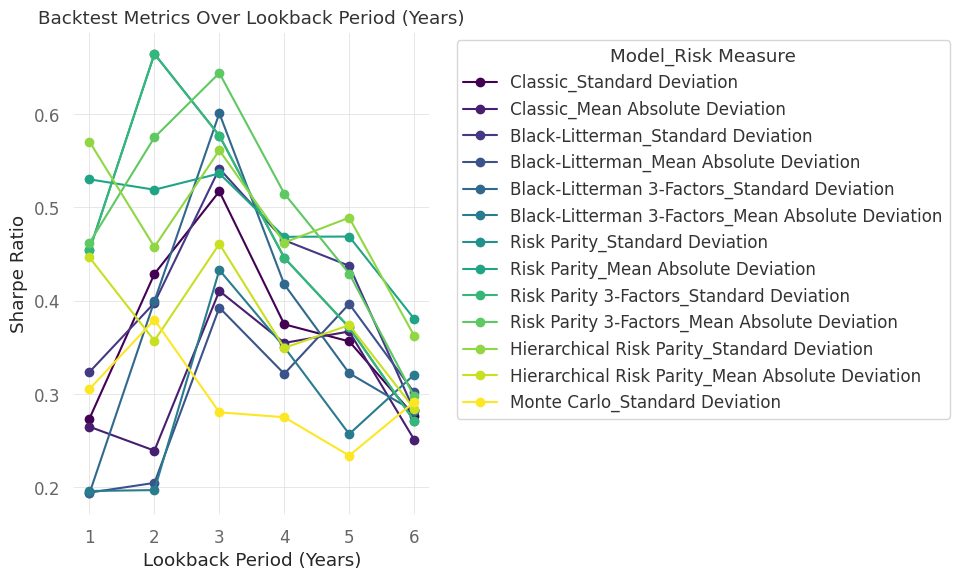

In [139]:
num_colors = len(sharpe_ratios.columns)
colors = cm.viridis(np.linspace(0, 1, num_colors))

# Replace Mean Variance with Classic
# sharpe_ratios.columns = sharpe_ratios.columns.str.replace("Mean Variance", "Classic")

sharpe_ratios.plot(figsize=(10, 6), marker="o", color=colors)

plt.title("Backtest Metrics Over Lookback Period (Years)")
plt.xlabel("Lookback Period (Years)")
plt.ylabel("Sharpe Ratio")
plt.xticks(sharpe_ratios.index)
plt.legend(title="Model_Risk Measure", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.grid(True)
plt.tight_layout()

plt.show()

In [142]:
sharpe_ratios.to_parquet(
    "../data/backtest/validation/sharpe_ratios_all_lookback.parquet"
)

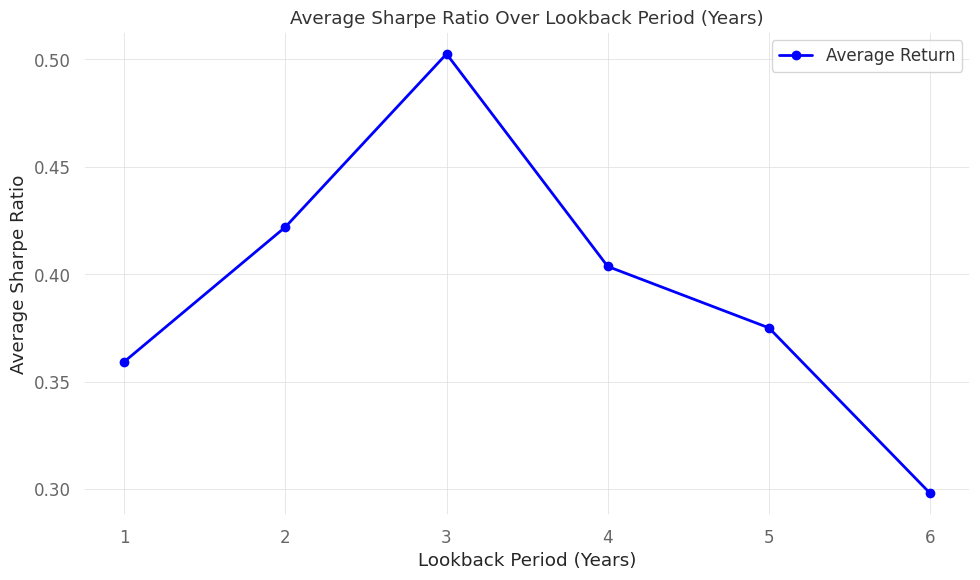

In [141]:
average_returns = sharpe_ratios.mean(axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    average_returns.index,
    average_returns,
    marker="o",
    color="blue",
    linewidth=2,
    label="Average Return",
)

ax.set_title("Average Sharpe Ratio Over Lookback Period (Years)")
ax.set_xlabel("Lookback Period (Years)")
ax.set_ylabel("Average Sharpe Ratio")
ax.set_xticks(average_returns.index)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

### Sharpe Ratio Rankings with a 3 year lookback period

In [14]:
df_T = sharpe_ratios.T
df_T = df_T[3].sort_values(ascending=False)
df_T

Risk Parity 3-Factors_Mean Absolute Deviation        0.656139
Black-Litterman 3-Factors_Standard Deviation         0.610450
Risk Parity_Standard Deviation                       0.586573
Risk Parity 3-Factors_Standard Deviation             0.586573
Hierarchical Risk Parity_Standard Deviation          0.574227
Black-Litterman_Standard Deviation                   0.551894
Risk Parity_Mean Absolute Deviation                  0.542209
Classic_Standard Deviation                           0.526228
Hierarchical Risk Parity_Mean Absolute Deviation     0.474889
Black-Litterman 3-Factors_Mean Absolute Deviation    0.444397
Classic_Mean Absolute Deviation                      0.416602
Black-Litterman_Mean Absolute Deviation              0.404792
Monte Carlo_Standard Deviation                       0.286778
Name: 3, dtype: float64

## 2. Run backtesting with 3 Factor Model and 5 Factors Model with 3 years of historical data
### Objective: To determine if 3 factors was sufficient

In [126]:
MODELS = [
    "Classic",
    "Classic 3-Factors",
    "Classic 5-Factors",
    "Black-Litterman",
    "Black-Litterman 3-Factors",
    "Black-Litterman 5-Factors",
    "Risk Parity",
    "Risk Parity 3-Factors",
    "Risk Parity 5-Factors",
]

rm_names = [
    "Standard Deviation",
    "Mean Absolute Deviation",
]

In [135]:
year_data = {}
year_sharpe = {}


risk_measures_not_avail = {}
for model in MODELS:
    if model == "Monte Carlo":
        risk_measures = ["Standard Deviation"]
    elif "Risk Parity" in model and "Hierarchical" not in model:
        excluded = ["Worst Realization", "Average Drawdown", "Max Drawdown", "Range"]
        risk_measures = [risk for risk in rm_names if risk not in excluded]
    else:
        risk_measures = rm_names

    for rm in risk_measures:
        try:
            port = vbt.Portfolio.load(
                f"../data/backtest/pickle/{model}_{rm}_B3_Y21.pkl"
            )
            year_data[f"{model}_{rm}"] = port.value()
            year_sharpe[f"{model}_{rm}"] = qs.stats.sharpe(
                port.returns()[:"2024-03-01"]
            )
        except Exception as e:
            print(f"Model: {model}, Risk Measure: {rm} - {e} not available")
            if not model in risk_measures_not_avail:
                risk_measures_not_avail[model] = [rm]
            else:
                risk_measures_not_avail[model].append(rm)


returns_df = pd.DataFrame.from_dict(year_data, orient="index").T
sharpes_df = pd.DataFrame.from_dict(year_sharpe, orient="index")

In [143]:
sharpes_df_sorted = sharpes_df.sort_values(by=0, ascending=False)
sharpes_df_sorted.columns = ["Sharpe Ratio"]
# Change Mean Variance to Classic
sharpes_df_sorted.index = sharpes_df_sorted.index.str.replace(
    "Mean Variance", "Classic"
)
# Only keep indexes with Classic, Black-Litterman and Risk Parity
sharpes_df_sorted = sharpes_df_sorted[
    sharpes_df_sorted.index.str.contains("Classic|Black-Litterman|Risk Parity")
]
# Remove Hierarchical Risk Parity
sharpes_df_sorted = sharpes_df_sorted[
    ~sharpes_df_sorted.index.str.contains("Hierarchical")
]
sharpes_df_sorted.to_parquet(
    "../data/backtest/validation/sharpe_ratios_factors.parquet"
)
print(sharpes_df_sorted)

                                                   Sharpe Ratio
Risk Parity 3-Factors_Mean Absolute Deviation          0.644110
Risk Parity 5-Factors_Mean Absolute Deviation          0.644105
Black-Litterman 3-Factors_Standard Deviation           0.601003
Risk Parity 5-Factors_Standard Deviation               0.577057
Risk Parity 3-Factors_Standard Deviation               0.577057
Risk Parity_Standard Deviation                         0.577057
Black-Litterman_Standard Deviation                     0.541681
Risk Parity_Mean Absolute Deviation                    0.536454
Black-Litterman 5-Factors_Standard Deviation           0.522960
Classic_Standard Deviation                             0.517285
Classic 3-Factors_Standard Deviation                   0.517285
Classic 5-Factors_Standard Deviation                   0.517285
Black-Litterman 3-Factors_Mean Absolute Deviation      0.433003
Classic 3-Factors_Mean Absolute Deviation              0.410591
Classic 5-Factors_Mean Absolute Deviatio

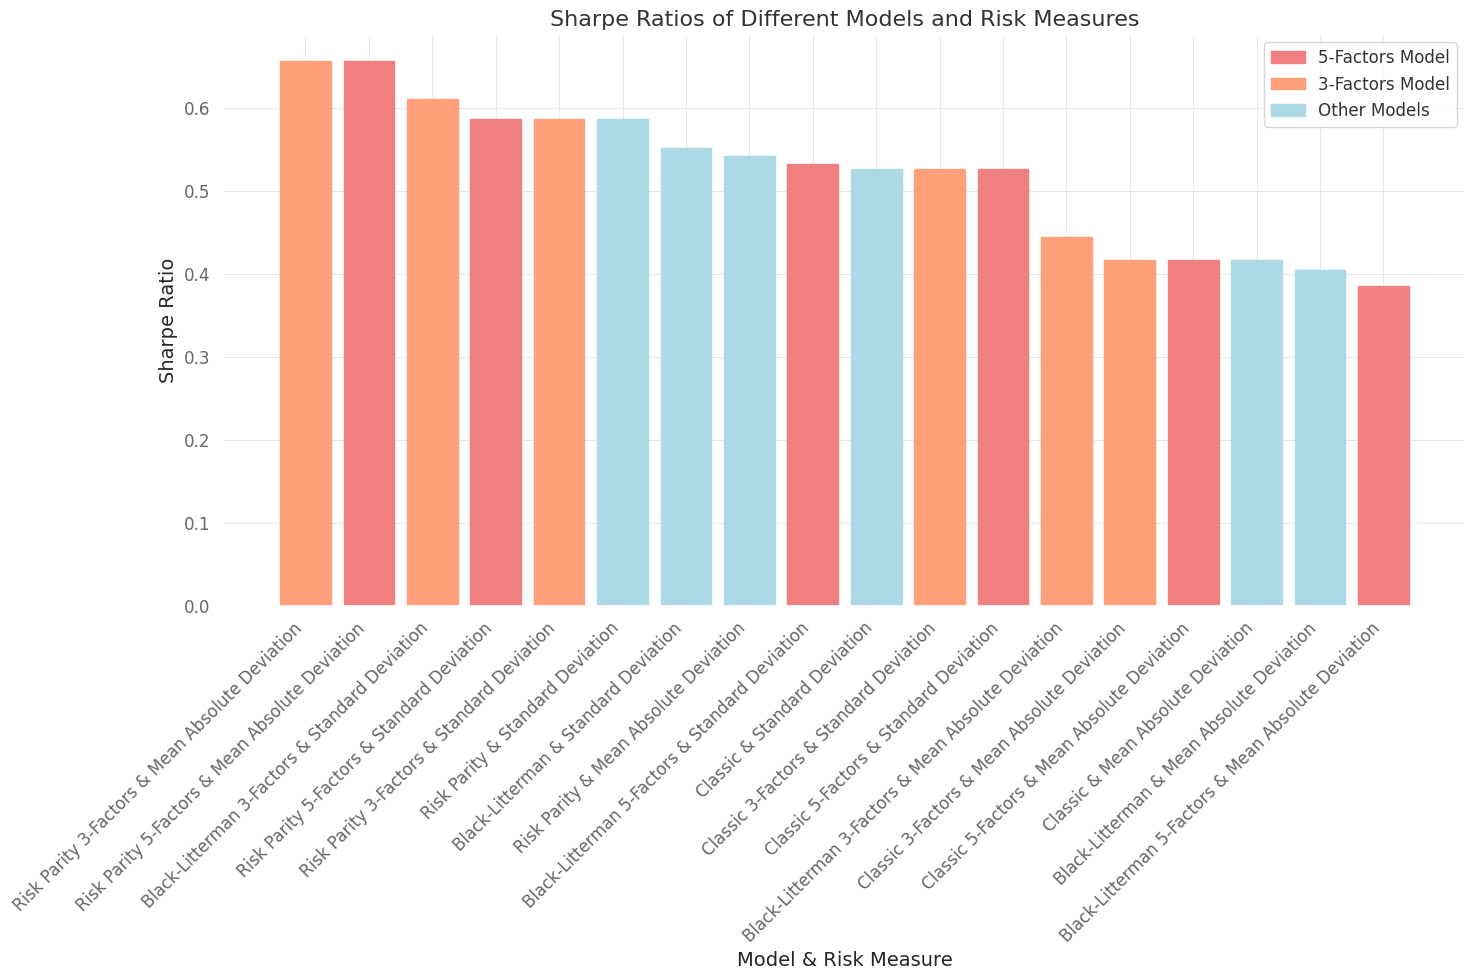

In [133]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(
    sharpes_df_sorted.index.str.replace("_", " & "),
    sharpes_df_sorted["Sharpe Ratio"],
    color="skyblue",
)

ax.set_title("Sharpe Ratios of Different Models and Risk Measures", fontsize=16)
ax.set_xlabel("Model & Risk Measure", fontsize=14)
ax.set_ylabel("Sharpe Ratio", fontsize=14)

colors = []
for index in sharpes_df_sorted.index:
    if "5-Factors" in index:
        colors.append("lightcoral")
    elif "3-Factors" in index:
        colors.append("lightsalmon")
    else:
        colors.append("lightblue")

for i, bar in enumerate(ax.patches):
    bar.set_color(colors[i])

# Add horizontal gridlines
ax.yaxis.grid(True)

# Add legend
ax.legend(
    handles=[
        plt.Rectangle((0, 0), 1, 1, color=color)
        for color in ["lightcoral", "lightsalmon", "lightblue"]
    ],
    labels=["5-Factors Model", "3-Factors Model", "Other Models"],
)

plt.xticks(rotation=45, ha="right", fontsize=12)
plt.tight_layout()

plt.show()

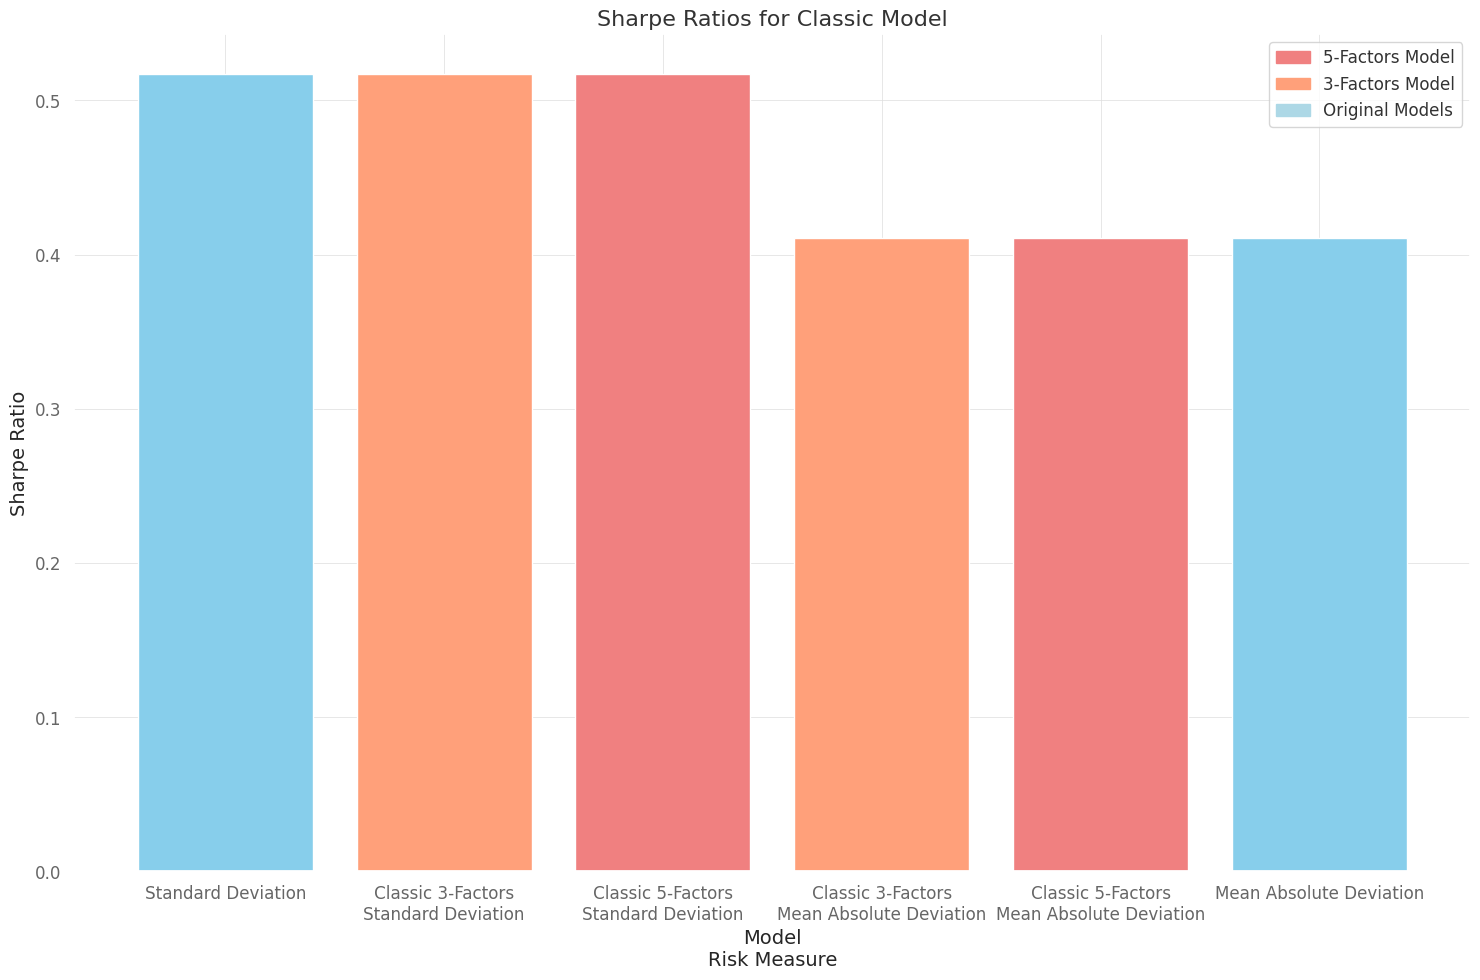

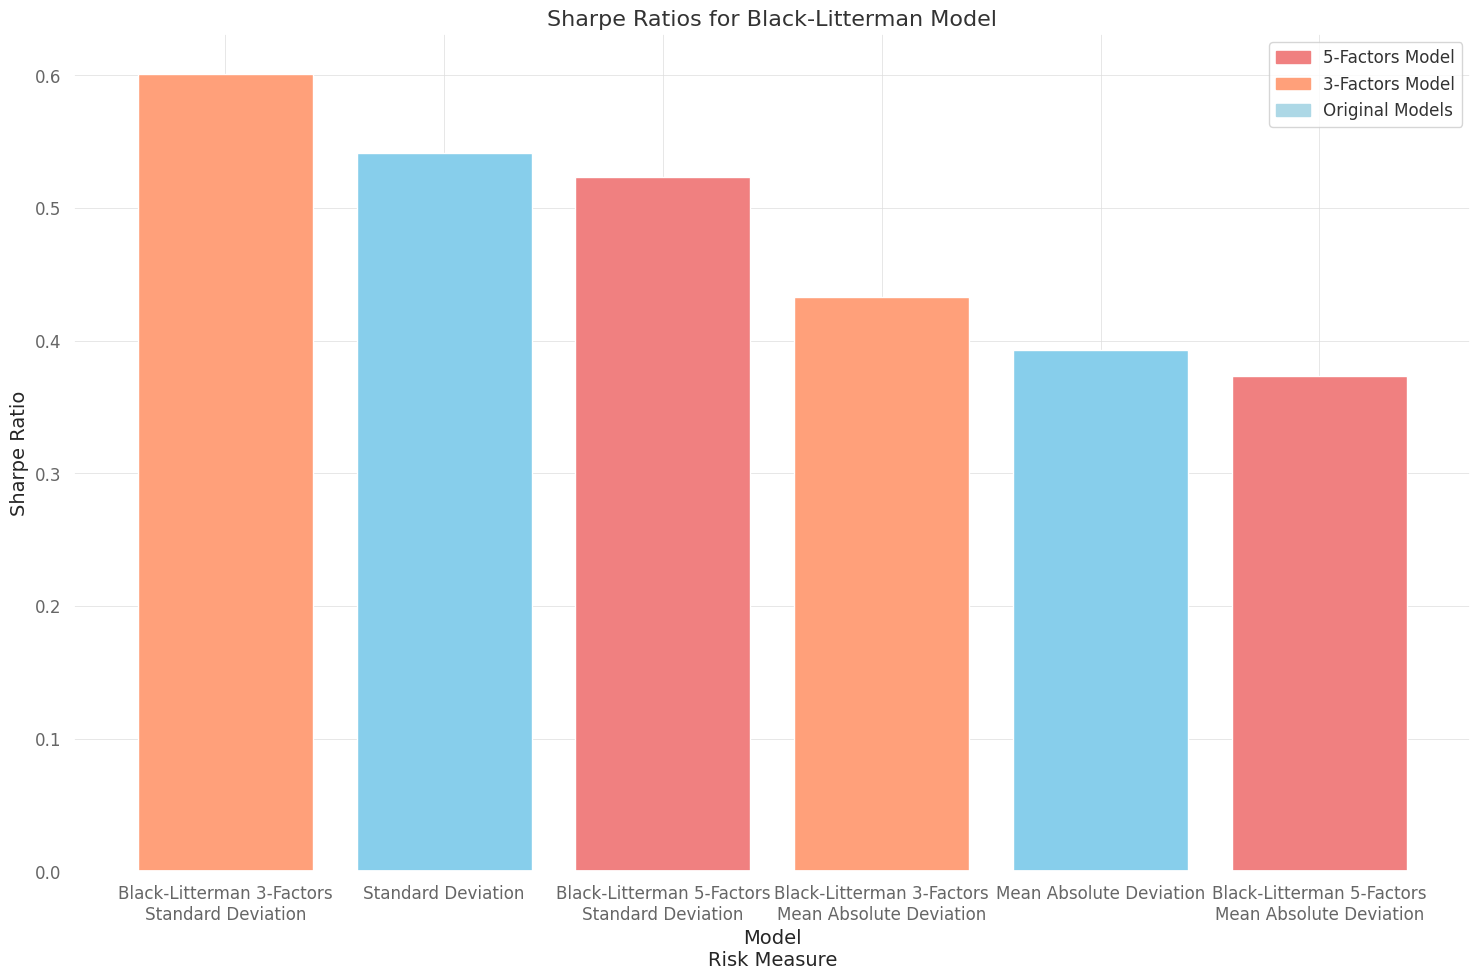

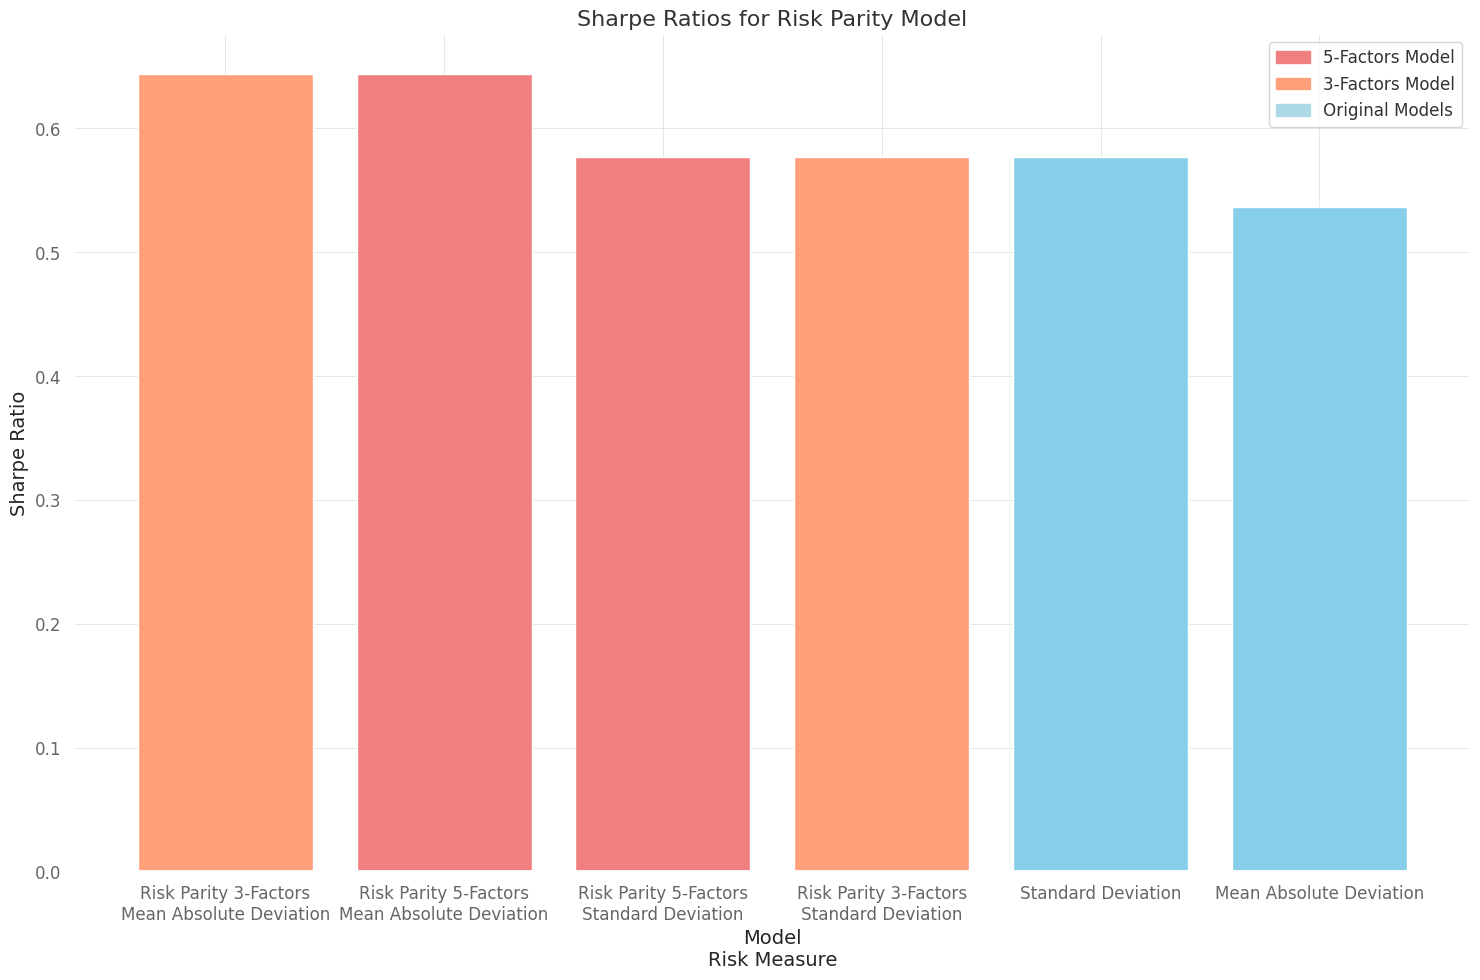

In [137]:
import matplotlib.pyplot as plt


# Create a function to plot each model type
def plot_sharpe_ratios(dataframe, model_type):
    # Filter dataframe for the model type
    df_filtered = dataframe[dataframe.index.str.startswith(model_type)]

    # Sort the filtered dataframe
    df_sorted = df_filtered.sort_values(by="Sharpe Ratio", ascending=False)

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))
    # Set the title and labels with the model type
    ax.set_title(f"Sharpe Ratios for {model_type} Model", fontsize=16)
    ax.set_xlabel("Model\nRisk Measure", fontsize=14)
    ax.set_ylabel("Sharpe Ratio", fontsize=14)

    bar_colors = [
        (
            "lightcoral"
            if "5-Factors" in idx
            else "lightsalmon" if "3-Factors" in idx else "skyblue"
        )
        for idx in df_sorted.index
    ]

    # Plot bars with the respective colors
    ax.bar(
        df_sorted.index.str.replace(model_type + "_", "").str.replace("_", "\n"),
        df_sorted["Sharpe Ratio"],
        color=bar_colors,
    )

    ax.yaxis.grid(True)
    ax.legend(
        handles=[
            plt.Rectangle((0, 0), 1, 1, color=color)
            for color in ["lightcoral", "lightsalmon", "lightblue"]
        ],
        labels=["5-Factors Model", "3-Factors Model", "Original Models"],
    )

    # plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.tight_layout()

    # Show the plot
    plt.show()


model_types = ["Classic", "Black-Litterman", "Risk Parity"]

for model_type in model_types:
    plot_sharpe_ratios(sharpes_df_sorted, model_type)

## Conclusion: 
1. Factor models were not useful for classic portfolios
2. 3 factors was sufficient for risk parity portfolios
3. 5 factors was useful for black-litterman portfolio

In [1]:
MODELS = [
    "Classic",
    "Black-Litterman",
    "Black-Litterman 3-Factors",
    "Black-Litterman 5-Factors",
    "Risk Parity",
    "Risk Parity 3-Factors",
    "Hierarchical Risk Parity",
    "Monte Carlo",
]

rm_names = [
    "Standard Deviation",
    "Mean Absolute Deviation",
    "Semi Standard Deviation",
    "First Lower Partial Moment",
    "Second Lower Partial Moment",
    "Entropic Value at Risk",
    "Worst Realization",
    "Range",
    "Max Drawdown",
    "Average Drawdown",
    "Conditional Drawdown at Risk",
    "Entropic Drawdown at Risk",
    "Ulcer Index",
]

In [7]:
import quantstats as qs
import vectorbt as vbt
import numpy as np
import pandas as pd

year_data = {}
risk_measures_not_avail = {}

for model in MODELS:
    if model == "Monte Carlo":
        risk_measures = ["Standard Deviation"]
    elif "Risk Parity" in model and "Hierarchical" not in model:
        excluded = ["Worst Realization", "Average Drawdown", "Max Drawdown", "Range"]
        risk_measures = [risk for risk in rm_names if risk not in excluded]
    else:
        risk_measures = rm_names

    for rm in risk_measures:
        try:
            port = vbt.Portfolio.load(
                f"../data/backtest/pickle/{model}_{rm}_B3_Y21.pkl"
            )

            if model == "Risk Parity 3-Factors":
                sharpe = qs.stats.sharpe(port.returns()[:"2024-03-01"]).round(3)
                original_port = vbt.Portfolio.load(
                    f"../data/backtest/pickle/Risk Parity_{rm}_B3_Y21.pkl"
                )
                original_sharpe = qs.stats.sharpe(
                    original_port.returns()[:"2024-03-01"]
                ).round(3)
                print(f"Original Sharpe: {original_sharpe}, New Sharpe: {sharpe}")
                if original_sharpe == sharpe:
                    if not model in risk_measures_not_avail:
                        risk_measures_not_avail[model] = [rm]
                    else:
                        risk_measures_not_avail[model].append(rm)
                    continue

            year_data[f"{model}_{rm}"] = port.value()

        except Exception as e:
            print(f"Model: {model}, Risk Measure: {rm} - {e} not available")
            if not model in risk_measures_not_avail:
                risk_measures_not_avail[model] = [rm]
            else:
                risk_measures_not_avail[model].append(rm)

returns_df = pd.DataFrame.from_dict(year_data, orient="index").T

Original Sharpe: 0.577, New Sharpe: 0.577
Original Sharpe: 0.536, New Sharpe: 0.644
Original Sharpe: 0.7, New Sharpe: 0.62
Original Sharpe: 0.481, New Sharpe: 0.481
Original Sharpe: 0.501, New Sharpe: 0.501
Original Sharpe: 0.516, New Sharpe: 0.516
Original Sharpe: 0.47, New Sharpe: 0.47
Original Sharpe: 0.466, New Sharpe: 0.466
Original Sharpe: 0.492, New Sharpe: 0.492


In [8]:
# Print risk measures not available for each model
rm_to_exclude = set()
for model, risk_measures in risk_measures_not_avail.items():
    print(f"{model}: {risk_measures}")
    rm_to_exclude.update(risk_measures)

# Print the set of risk measures
print(rm_to_exclude)

Risk Parity 3-Factors: ['Standard Deviation', 'First Lower Partial Moment', 'Second Lower Partial Moment', 'Entropic Value at Risk', 'Conditional Drawdown at Risk', 'Entropic Drawdown at Risk', 'Ulcer Index']
{'First Lower Partial Moment', 'Second Lower Partial Moment', 'Entropic Drawdown at Risk', 'Ulcer Index', 'Conditional Drawdown at Risk', 'Standard Deviation', 'Entropic Value at Risk'}


### Plotting of backtesting results

In [9]:
sti_returns = pd.read_parquet("../data/obtain_data/STI.parquet")
# Value of portfolio if 100000 was invested in the beginning of 2003
sti_returns = sti_returns.loc["2003-01-01":]
sti_returns = sti_returns["Close"].pct_change().dropna()
sti_returns = (sti_returns + 1).cumprod() * 100000
print(sti_returns)

Date
2003-01-03    100295.668595
2003-01-06     99673.648901
2003-01-07     98709.562232
2003-01-08     99726.041241
2003-01-09     99933.381139
                  ...      
2024-04-01    242136.105321
2024-04-02    243096.454901
2024-04-03    241220.673904
2024-04-04    242145.096263
2024-04-05    240632.351968
Name: Close, Length: 5317, dtype: float64


In [10]:
values = returns_df  # ["2006-01-01":]

first_diff_index = (values != 100000).idxmax().min()
values = values.loc[first_diff_index:]
values["STI_Standard Deviation"] = sti_returns.copy()

/tmp/ipykernel_738533/3913240829.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values["STI_Standard Deviation"] = sti_returns.copy()


            Classic_Standard Deviation  Classic_Mean Absolute Deviation  \
2003-01-02               100000.000000                    100000.000000   
2003-01-03               102494.549003                    102635.745473   
2003-01-06               102384.903858                    102335.922228   
2003-01-07               100858.986012                    100392.922588   
2003-01-08               100843.162733                    100162.970196   

            Classic_Semi Standard Deviation  \
2003-01-02                    100000.000000   
2003-01-03                    102571.862210   
2003-01-06                    102530.852937   
2003-01-07                    101064.639605   
2003-01-08                    101153.863727   

            Classic_First Lower Partial Moment  \
2003-01-02                       100000.000000   
2003-01-03                       102650.765865   
2003-01-06                       102381.154979   
2003-01-07                       100478.105021   
2003-01-08      

/home/vrsb/miniconda3/envs/fast/lib/python3.11/site-packages/quantstats/utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()


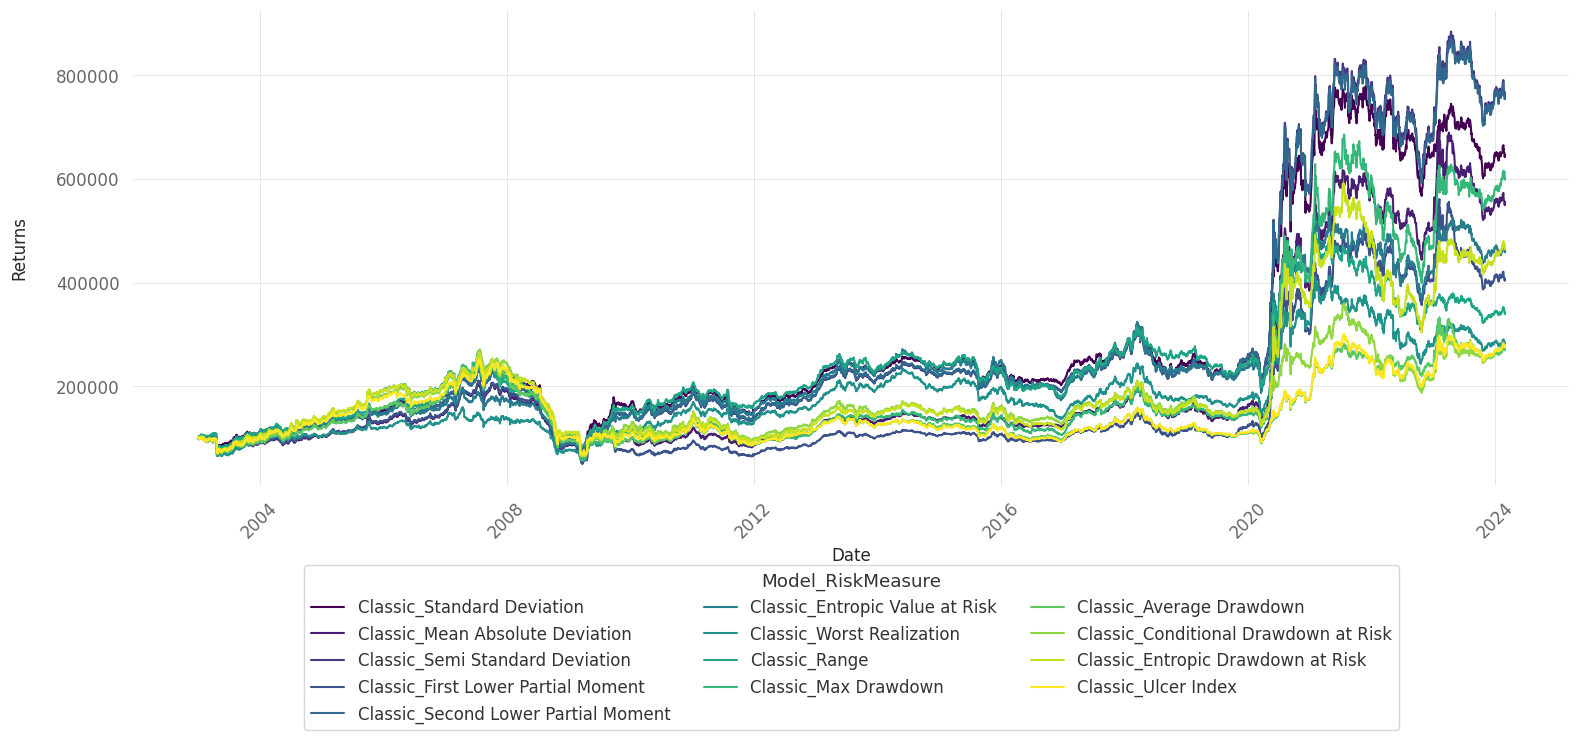

In [11]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import quantstats as qs

values = values[:"2024-03-01"]
values.to_parquet("../data/backtest/validation/all_models_values_Y21.parquet")
values = pd.read_parquet("../data/backtest/validation/all_models_values_Y21.parquet")
print(values.head())

# Top 5 sharpes.index model names
sharpes = qs.stats.sharpe(values)
sharpes = sharpes.sort_values(ascending=False).rename("Sharpe Ratio")
top_5_models = sharpes.index[:6]
# values = values[top_5_models]
# Values of all classic models
values = values[[model for model in values.columns if "Classic" in model]]
# Print the classic models that did not have a 200K value in 2020
print([model for model in values.columns if values[model].iloc[-1] < 200000])
# Models that have a 200K value in 2020
values = values[[model for model in values.columns if values[model].iloc[-1] > 200000]]


num_colors = len(values.columns)
colors = cm.viridis(np.linspace(0, 1, num_colors))

fig, ax = plt.subplots(figsize=(16, 7))

for i, col in enumerate(values.columns):
    ax.plot(values.index, values[col], color=colors[i], label=col)

ax.set_xlabel("Date", fontsize=12)
plt.xticks(rotation=45)

ax.set_ylabel("Returns", fontsize=12, labelpad=20)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    fontsize=12,
    title="Model_RiskMeasure",
)

plt.show()

QS Sharpe Calc: Sharpe Ratio = (Portfolio Return - Risk-Free Rate) / Portfolio Standard Deviation

In [14]:
values = pd.read_parquet("../data/backtest/validation/all_models_values_Y21.parquet")
sharpes = qs.stats.sharpe(values)
sharpes = sharpes.sort_values(ascending=False).rename("Sharpe Ratio")
max_sharpe = sharpes.idxmax()
sharpes = sharpes.round(3)
print(sharpes)
print(f"Max return: {max_sharpe}\n")
print(f"Benchmark Sharpe Ratio {sharpes['STI_Standard Deviation']}")
sharpes = sharpes.to_frame()
sharpes["Model"], sharpes["Risk Measure"] = zip(*sharpes.index.str.split("_"))
sharpes.loc[sharpes["Model"] == "STI", "Risk Measure"] = None
sharpes = sharpes[["Model", "Risk Measure", "Sharpe Ratio"]]
sharpes.reset_index(drop=True, inplace=True)
sharpes.to_csv("../data/backtest/validation/sharpe_ratios_Y21.csv")

Risk Parity_Semi Standard Deviation                    0.749
Risk Parity 3-Factors_Mean Absolute Deviation          0.690
Risk Parity 3-Factors_Semi Standard Deviation          0.663
Black-Litterman 3-Factors_Standard Deviation           0.644
Risk Parity_Standard Deviation                         0.618
                                                       ...  
Black-Litterman 5-Factors_Max Drawdown                 0.225
Black-Litterman 5-Factors_Entropic Drawdown at Risk    0.224
Black-Litterman_Conditional Drawdown at Risk           0.223
Black-Litterman_Max Drawdown                           0.185
Black-Litterman_Entropic Drawdown at Risk              0.169
Name: Sharpe Ratio, Length: 78, dtype: float64
Max return: Risk Parity_Semi Standard Deviation

Benchmark Sharpe Ratio 0.328


/home/vrsb/miniconda3/envs/fast/lib/python3.11/site-packages/quantstats/utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()


In [15]:
# Calculate Sortino Ratio
sortinos = qs.stats.sortino(values)
sortinos = sortinos.sort_values(ascending=False).rename("Sortino Ratio")
print("\nSortino Ratios (sorted):")
sortinos = sortinos.round(3)
print(sortinos)
max_sortino = sortinos.idxmax()
print(
    f"Max Sortino Ratio: {max_sortino} with a Sortino Ratio of {sortinos.loc[max_sortino]}"
)
print(f"Benchmark Sortino Ratio: {sortinos['STI_Standard Deviation']}")
sortinos = sortinos.to_frame()
sortinos["Model"], sortinos["Risk Measure"] = zip(*sortinos.index.str.split("_"))
sortinos.loc[sortinos["Model"] == "STI", "Risk Measure"] = None
sortinos = sortinos[["Model", "Risk Measure", "Sortino Ratio"]]
sortinos.reset_index(drop=True, inplace=True)
sortinos.to_csv("../data/backtest/validation/sortino_ratios_Y21.csv")


Sortino Ratios (sorted):
Risk Parity_Semi Standard Deviation                    1.064
Risk Parity 3-Factors_Mean Absolute Deviation          0.947
Risk Parity 3-Factors_Semi Standard Deviation          0.924
Black-Litterman 3-Factors_Standard Deviation           0.899
Risk Parity_Standard Deviation                         0.849
                                                       ...  
Black-Litterman 5-Factors_Max Drawdown                 0.318
Black-Litterman_Conditional Drawdown at Risk           0.317
Black-Litterman 5-Factors_Entropic Drawdown at Risk    0.316
Black-Litterman_Max Drawdown                           0.257
Black-Litterman_Entropic Drawdown at Risk              0.234
Name: Sortino Ratio, Length: 78, dtype: float64
Max Sortino Ratio: Risk Parity_Semi Standard Deviation with a Sortino Ratio of 1.064
Benchmark Sortino Ratio: 0.463


/home/vrsb/miniconda3/envs/fast/lib/python3.11/site-packages/quantstats/utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()


In [16]:
# Calculate Calmar Ratio
calmars = qs.stats.calmar(values)
calmars = calmars.sort_values(ascending=False).rename("Calmar Ratio")
print("Calmar Ratios (sorted):")
calmars = calmars.round(3)
print(calmars)
max_calmar = calmars.idxmax()
print(
    f"Max Calmar Ratio: {max_calmar} with a Calmar Ratio of {calmars.loc[max_calmar]}\n"
)
print(f"Benchmark Calmar Ratio: {calmars['STI_Standard Deviation']}")
calmars = calmars.to_frame()
calmars["Model"], calmars["Risk Measure"] = zip(*calmars.index.str.split("_"))
calmars.loc[calmars["Model"] == "STI", "Risk Measure"] = None
calmars = calmars[["Model", "Risk Measure", "Calmar Ratio"]]
calmars.reset_index(drop=True, inplace=True)
calmars.to_csv("../data/backtest/validation/calmar_ratios_Y21.csv")

Calmar Ratios (sorted):
Risk Parity_Semi Standard Deviation                    0.105
Classic_Semi Standard Deviation                        0.098
Classic_Second Lower Partial Moment                    0.097
Black-Litterman 3-Factors_Standard Deviation           0.097
Classic_Standard Deviation                             0.091
                                                       ...  
Black-Litterman 5-Factors_Max Drawdown                 0.027
Black-Litterman 5-Factors_Entropic Drawdown at Risk    0.026
Black-Litterman_Conditional Drawdown at Risk           0.025
Black-Litterman_Max Drawdown                           0.017
Black-Litterman_Entropic Drawdown at Risk              0.014
Name: Calmar Ratio, Length: 78, dtype: float64
Max Calmar Ratio: Risk Parity_Semi Standard Deviation with a Calmar Ratio of 0.105

Benchmark Calmar Ratio: 0.045


/home/vrsb/miniconda3/envs/fast/lib/python3.11/site-packages/quantstats/utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()


In [17]:
volatilities = qs.stats.volatility(values)
volatilities = volatilities.sort_values(ascending=True).rename("Volatility")
volatilities = volatilities.round(3)
print(volatilities)
min_vol = volatilities.idxmin()
print(f"Min volatility: {min_vol}\n")
print(f"Benchmark Volatility: {volatilities['STI_Standard Deviation']}")
volatilities = volatilities.to_frame()
volatilities["Model"], volatilities["Risk Measure"] = zip(
    *volatilities.index.str.split("_")
)
volatilities.loc[volatilities["Model"] == "STI", "Risk Measure"] = None
volatilities = volatilities[["Model", "Risk Measure", "Volatility"]]
volatilities.reset_index(drop=True, inplace=True)
volatilities.to_csv("../data/backtest/validation/volatility_Y21.csv")

Risk Parity 3-Factors_Mean Absolute Deviation    0.103
Risk Parity_Standard Deviation                   0.104
Risk Parity_Second Lower Partial Moment          0.104
Risk Parity 3-Factors_Semi Standard Deviation    0.105
Risk Parity_Semi Standard Deviation              0.112
                                                 ...  
Classic_Conditional Drawdown at Risk             0.224
Classic_Entropic Drawdown at Risk                0.243
Classic_Max Drawdown                             0.252
Classic_Mean Absolute Deviation                  0.257
Classic_First Lower Partial Moment               0.297
Name: Volatility, Length: 78, dtype: float64
Min volatility: Risk Parity 3-Factors_Mean Absolute Deviation

Benchmark Volatility: 0.162


/home/vrsb/miniconda3/envs/fast/lib/python3.11/site-packages/quantstats/utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()


In [31]:
metrics_df = pd.DataFrame(
    {
        "Model_RiskMeasure": sharpes.index,
        "Sharpe Ratio": sharpes.values.flatten(),
        "Volatility": volatilities.values.flatten(),
        "Sortino Ratio": sortinos.values.flatten(),
        "Calmar Ratio": calmars.values.flatten(),
    }
)

metrics_df[["Model", "RiskMeasure"]] = metrics_df["Model_RiskMeasure"].str.split(
    "_", n=1, expand=True
)

print(metrics_df)

                                    Model_RiskMeasure  Sharpe Ratio  \
0                 Risk Parity_Semi Standard Deviation         0.759   
1       Risk Parity 3-Factors_Mean Absolute Deviation         0.702   
2       Risk Parity 3-Factors_Semi Standard Deviation         0.678   
3        Black-Litterman 3-Factors_Standard Deviation         0.654   
4                      Risk Parity_Standard Deviation         0.628   
..                                                ...           ...   
80             Black-Litterman 5-Factors_Max Drawdown         0.231   
81  Black-Litterman 5-Factors_Entropic Drawdown at...         0.230   
82       Black-Litterman_Conditional Drawdown at Risk         0.228   
83                       Black-Litterman_Max Drawdown         0.192   
84          Black-Litterman_Entropic Drawdown at Risk         0.176   

    Volatility  Sortino Ratio  Calmar Ratio                      Model  \
0        0.103          1.078         0.107                Risk Parity   

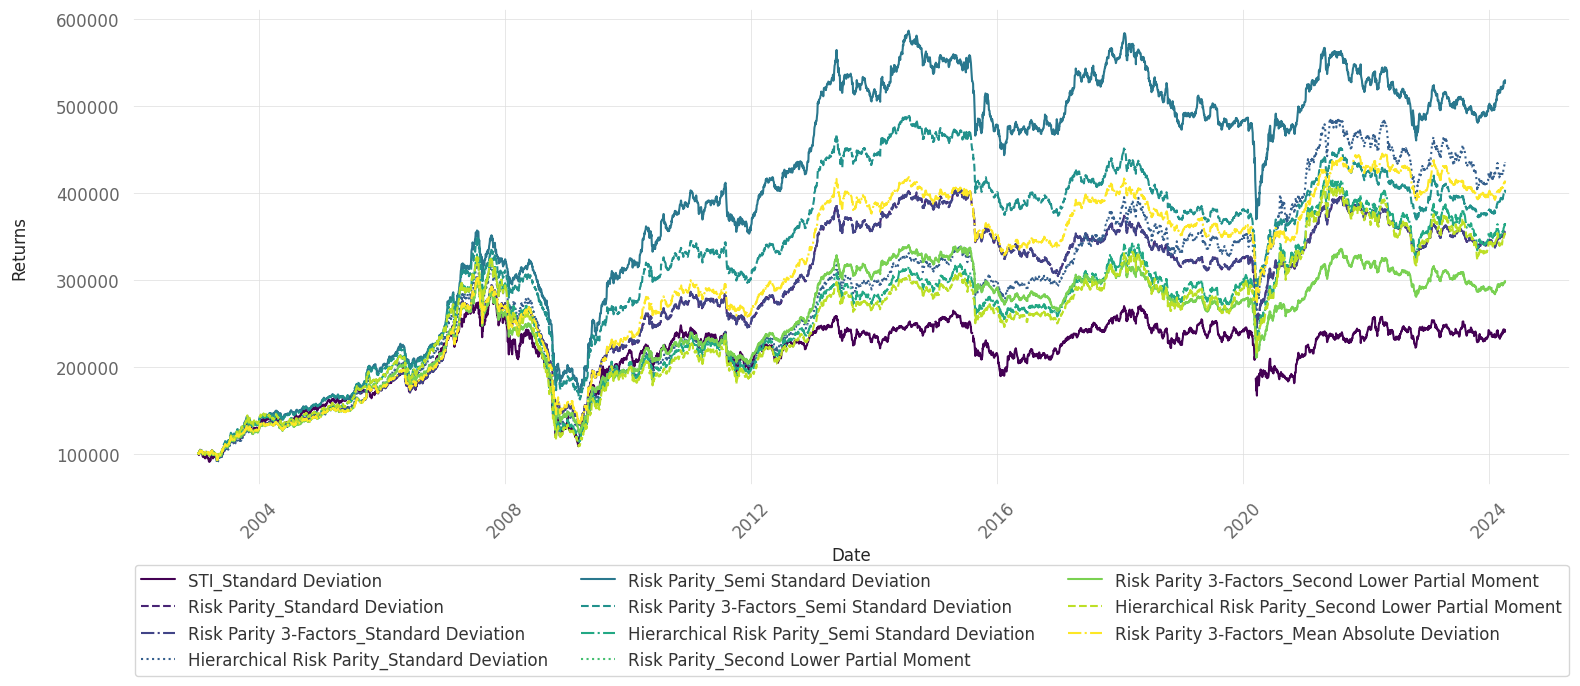

In [52]:
values_temp = values[
    [
        "STI_Standard Deviation",
        "Risk Parity_Standard Deviation",
        "Risk Parity 3-Factors_Standard Deviation",
        "Hierarchical Risk Parity_Standard Deviation",
        "Risk Parity_Semi Standard Deviation",
        "Risk Parity 3-Factors_Semi Standard Deviation",
        "Hierarchical Risk Parity_Semi Standard Deviation",
        "Risk Parity_Second Lower Partial Moment",
        "Risk Parity 3-Factors_Second Lower Partial Moment",
        "Hierarchical Risk Parity_Second Lower Partial Moment",
        "Risk Parity 3-Factors_Mean Absolute Deviation",
    ]
]

num_colors = len(values_temp.columns)
colors = cm.viridis(np.linspace(0, 1, num_colors))

line_styles = ["-", "--", "-.", ":"] * (num_colors // 4 + 1)

fig, ax = plt.subplots(figsize=(16, 7))

for i, col in enumerate(values_temp.columns):
    ax.plot(
        values_temp.index,
        values_temp[col],
        color=colors[i],
        linestyle=line_styles[i],
        label=col,
    )

ax.set_xlabel("Date", fontsize=12)
plt.xticks(rotation=45)

ax.set_ylabel("Returns", fontsize=12, labelpad=20)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])

# Use custom handles to create a more legible legend, or consider removing it entirely for clarity.
custom_lines = [
    plt.Line2D([0], [0], color=colors[i], linestyle=line_styles[i])
    for i in range(num_colors)
]
ax.legend(
    custom_lines,
    values_temp.columns,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    fontsize=12,
)

plt.show()

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_risk_measure(data, measure, title):
    # Set the size of the figure
    plt.figure(figsize=(10, 8))

    # Sort data by the measure in descending order and take the top 5
    top_five_data = data.sort_values(by=measure, ascending=False).head(5)

    # Create the bar plot
    sns_plot = sns.barplot(
        x=measure,
        y="Model",
        hue="RiskMeasure",
        data=data.sort_values(by=measure, ascending=False),
        palette="coolwarm",
    )

    # Set the plot title
    plt.title(title)

    # Adjust the layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Customize legend
    plt.legend(bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=3, frameon=False)

    # Loop through the top five data points to add a vertical line for each
    for value in top_five_data[measure]:
        plt.axvline(x=value, color="grey", linestyle="--", alpha=0.7)

    # Optionally, you can annotate the lines to make it clear what they represent
    for index, row in top_five_data.iterrows():
        plt.text(
            row[measure],
            plt.gca().get_ylim()[1],
            f" {row[measure]:.2f}",
            color="grey",
            va="bottom",
            alpha=0.7,
        )

    # Show the plot
    plt.show()

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_risk_measure(data, measure, title):
    plt.figure(figsize=(10, 8))

    sns.barplot(x=measure, y="Model", hue="RiskMeasure", data=data, palette="coolwarm")
    plt.title(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.legend(bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=3, frameon=False)
    plt.show()

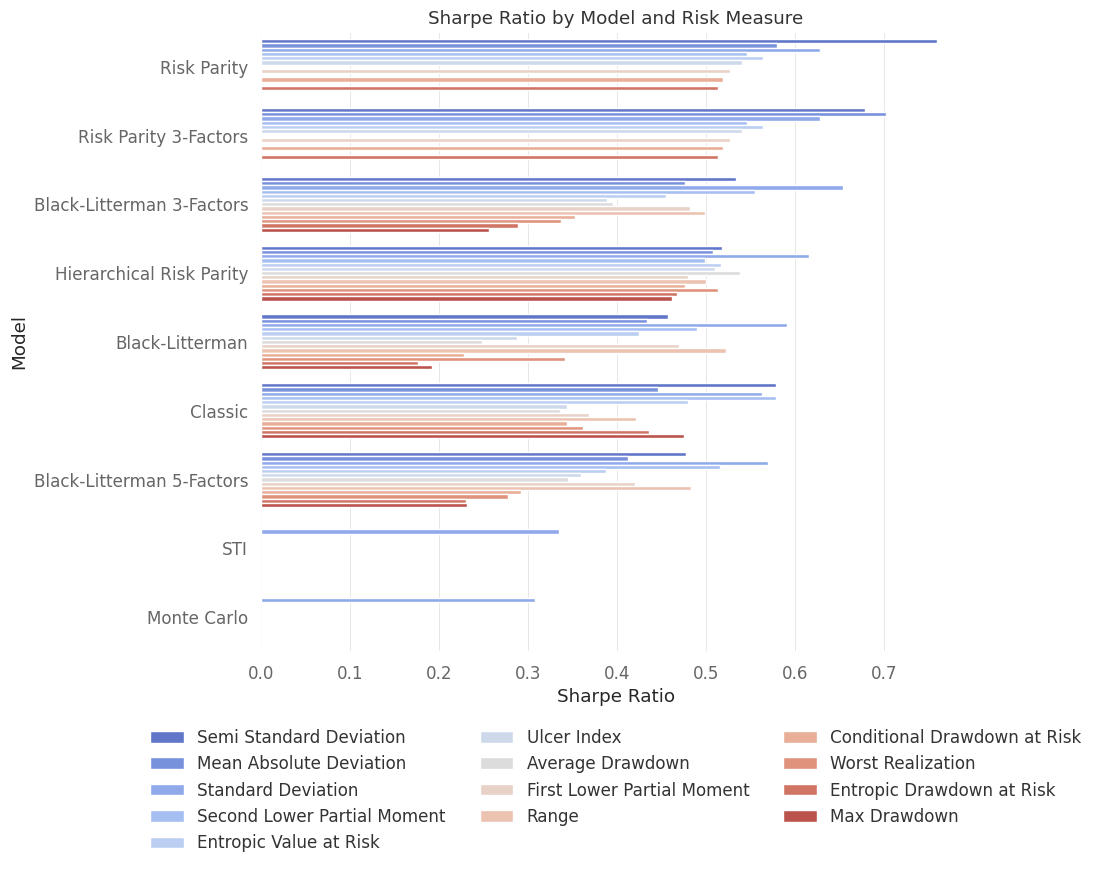

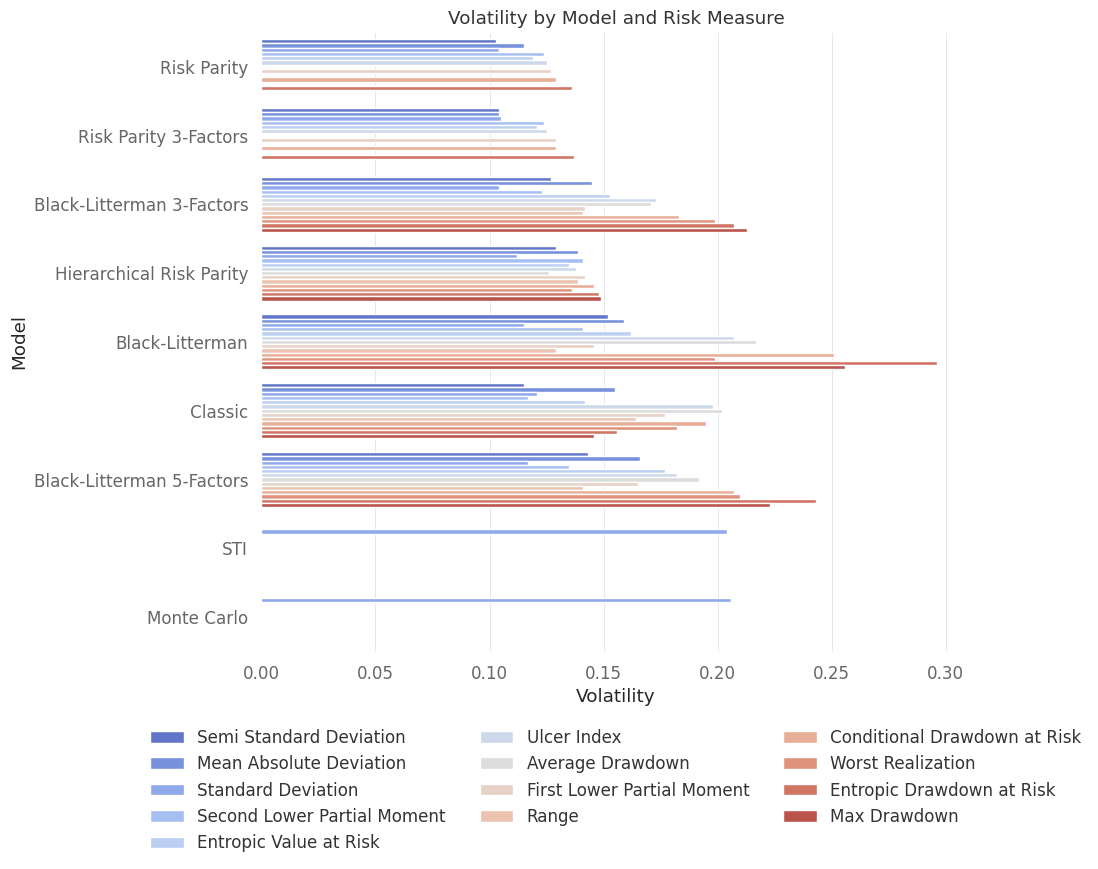

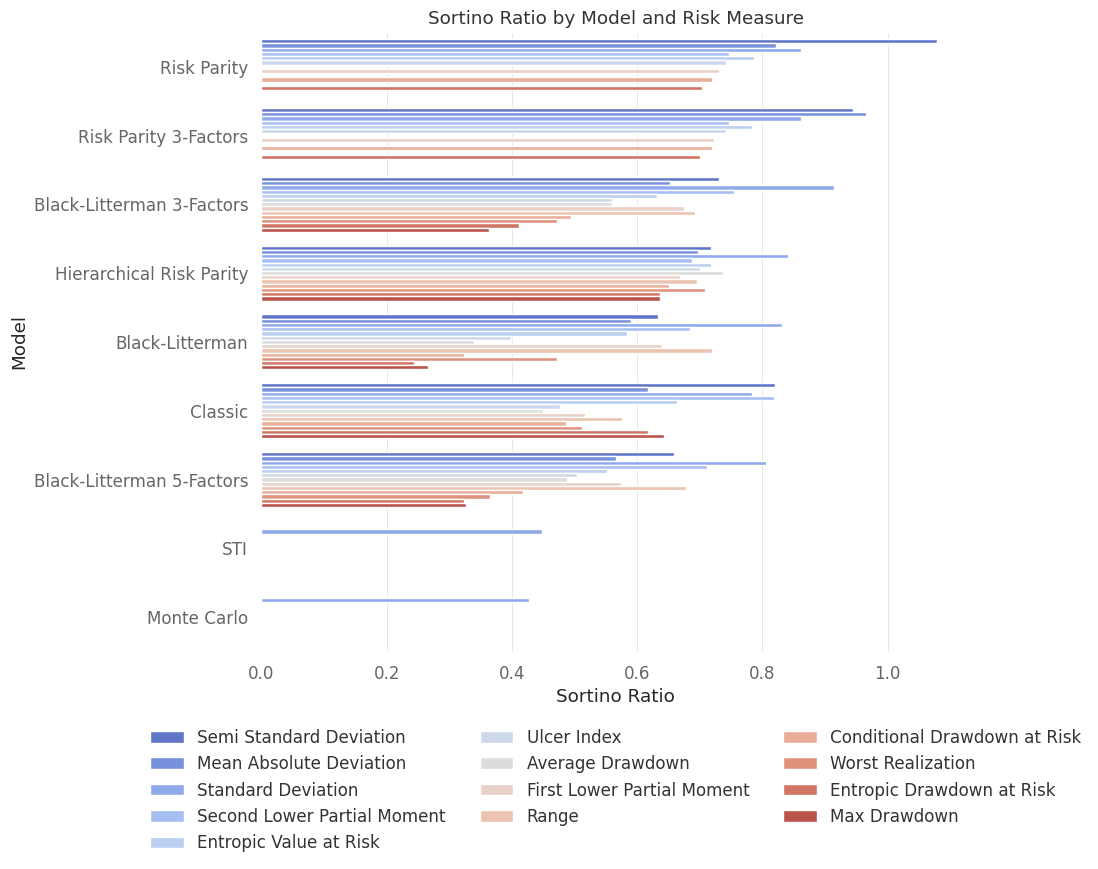

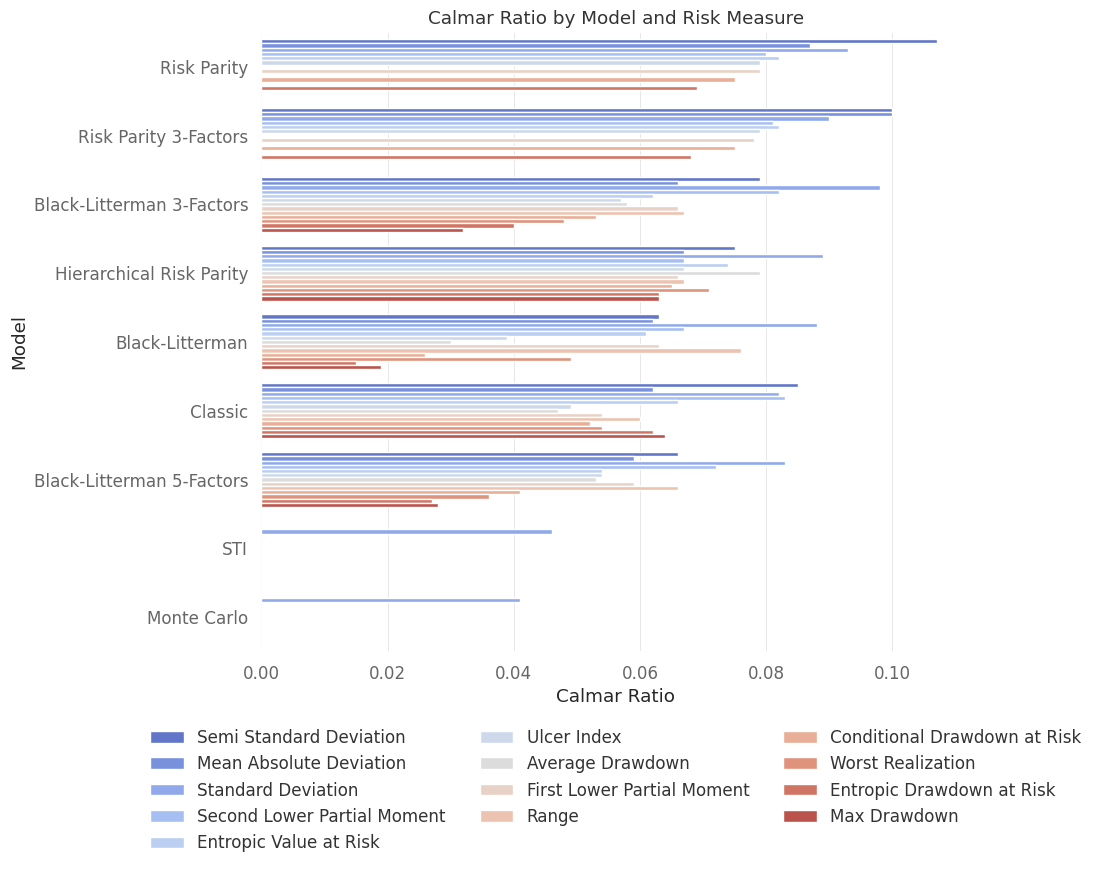

In [34]:
plot_risk_measure(metrics_df, "Sharpe Ratio", "Sharpe Ratio by Model and Risk Measure")
plot_risk_measure(metrics_df, "Volatility", "Volatility by Model and Risk Measure")
plot_risk_measure(
    metrics_df, "Sortino Ratio", "Sortino Ratio by Model and Risk Measure"
)
plot_risk_measure(metrics_df, "Calmar Ratio", "Calmar Ratio by Model and Risk Measure")

In [18]:
def calculate_metrics_cumulative(df, frequency):
    cumulative_metrics = pd.DataFrame()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    date_ranges = pd.date_range(df.index.min(), df.index.max(), freq=frequency)
    for idx, end_date in enumerate(date_ranges):
        if end_date > df.index.max():
            break
        # period_data = df.loc[date_ranges[idx-1]:end_date]
        period_data = df.loc[:end_date]
        sharpes = qs.stats.sharpe(period_data).round(3)
        volatilities = qs.stats.volatility(period_data).round(3)
        calmars = qs.stats.calmar(period_data).round(3)
        sortinos = qs.stats.sortino(period_data).round(3)
        metrics = pd.DataFrame(
            {
                "Date": end_date,
                "Model_RiskMeasure": sharpes.index,
                "Sharpe Ratio": sharpes.values,
                "Volatility": volatilities.values,
                "Calmar Ratio": calmars.values,
                "Sortino Ratio": sortinos.values,
            }
        )
        cumulative_metrics = pd.concat([cumulative_metrics, metrics])
    cumulative_metrics[["Model", "RiskMeasure"]] = cumulative_metrics[
        "Model_RiskMeasure"
    ].str.split("_", expand=True)
    return cumulative_metrics.reset_index(drop=True)


monthly_cumulative_metrics = calculate_metrics_cumulative(values, "MS")

/home/vrsb/miniconda3/envs/fast/lib/python3.11/site-packages/quantstats/utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()
/home/vrsb/miniconda3/envs/fast/lib/python3.11/site-packages/quantstats/utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[col] = data[col].pct_change()
/home/vrsb/miniconda3/envs/fast/lib/python3.11/site-packages/quantstats/utils.py:211: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct

In [19]:
monthly_cumulative_metrics.to_parquet(
    "../data/backtest/validation/monthly_cumulative_metrics_Y21.parquet"
)

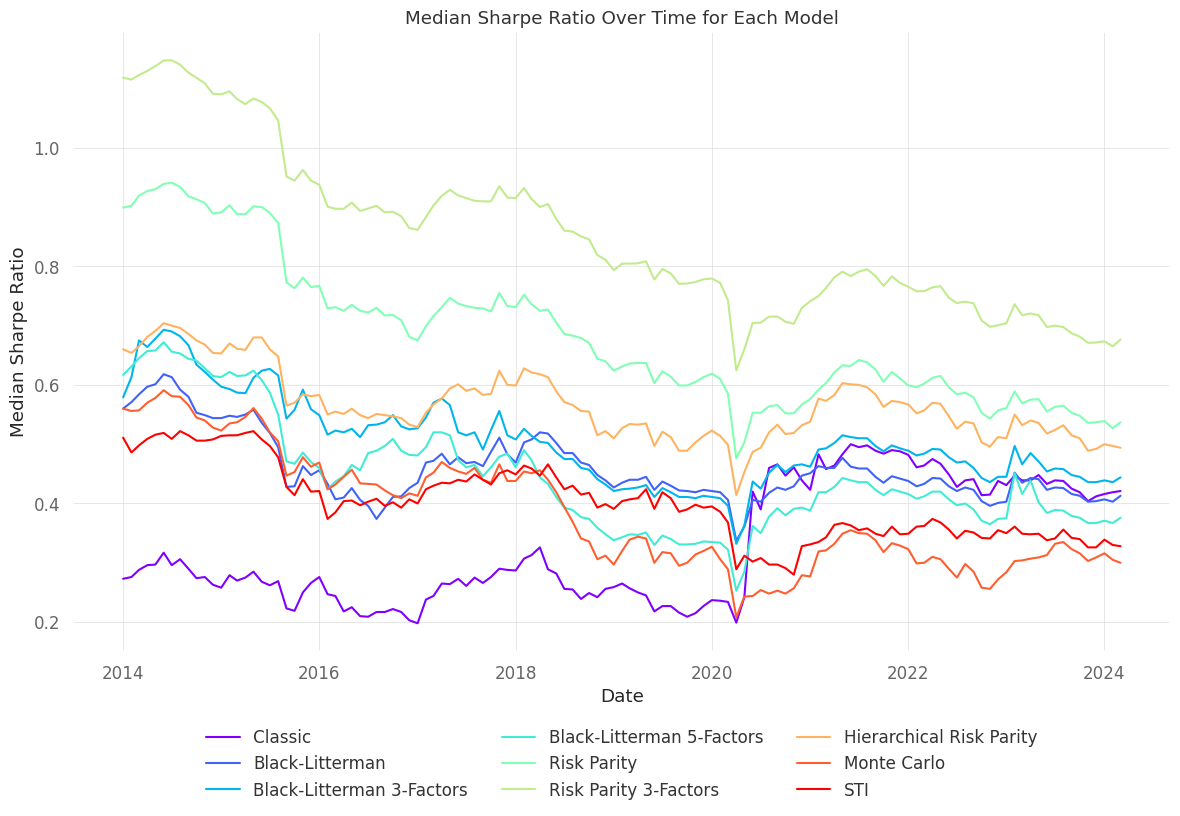

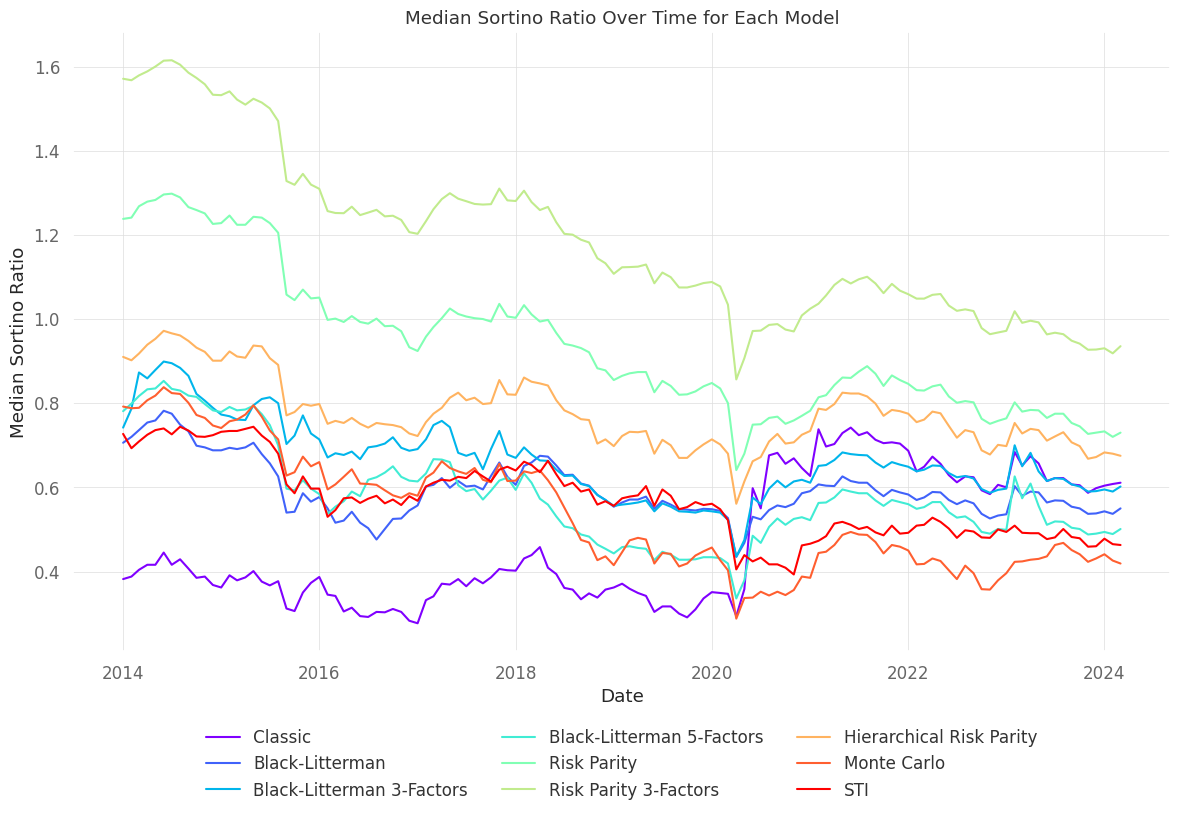

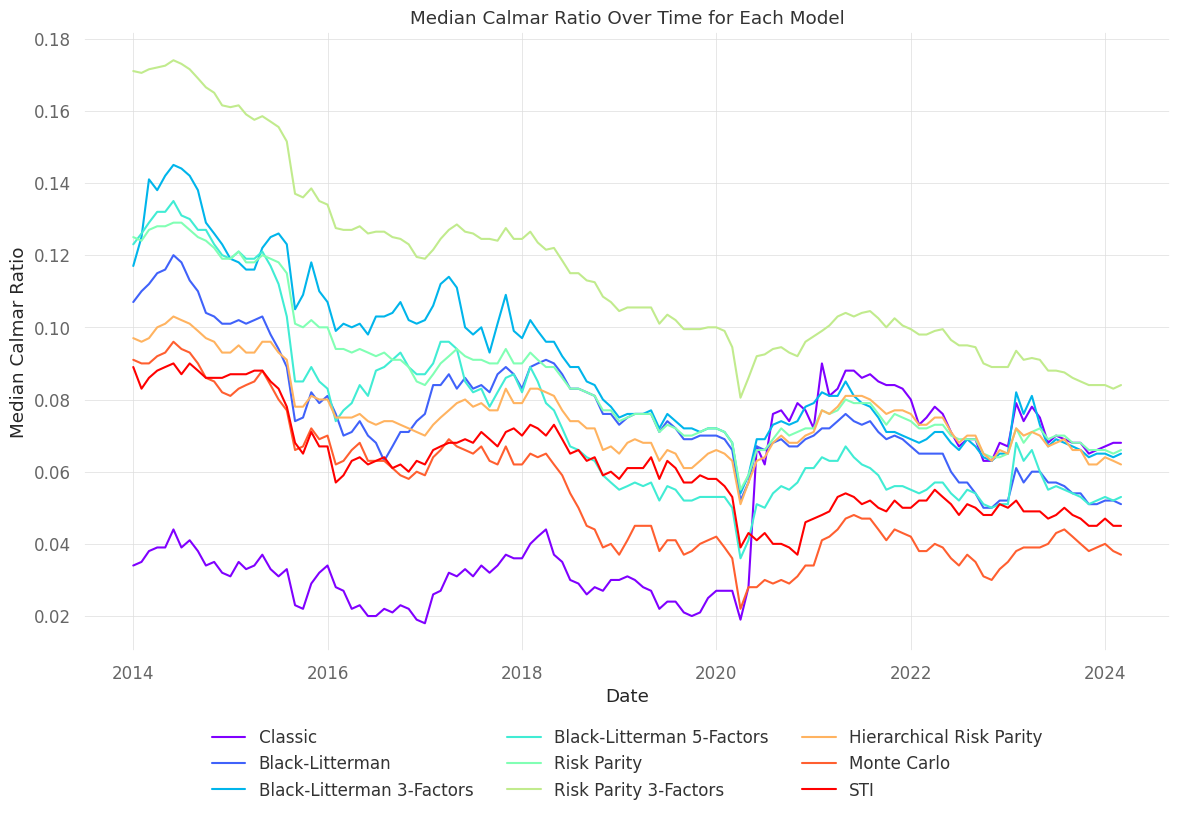

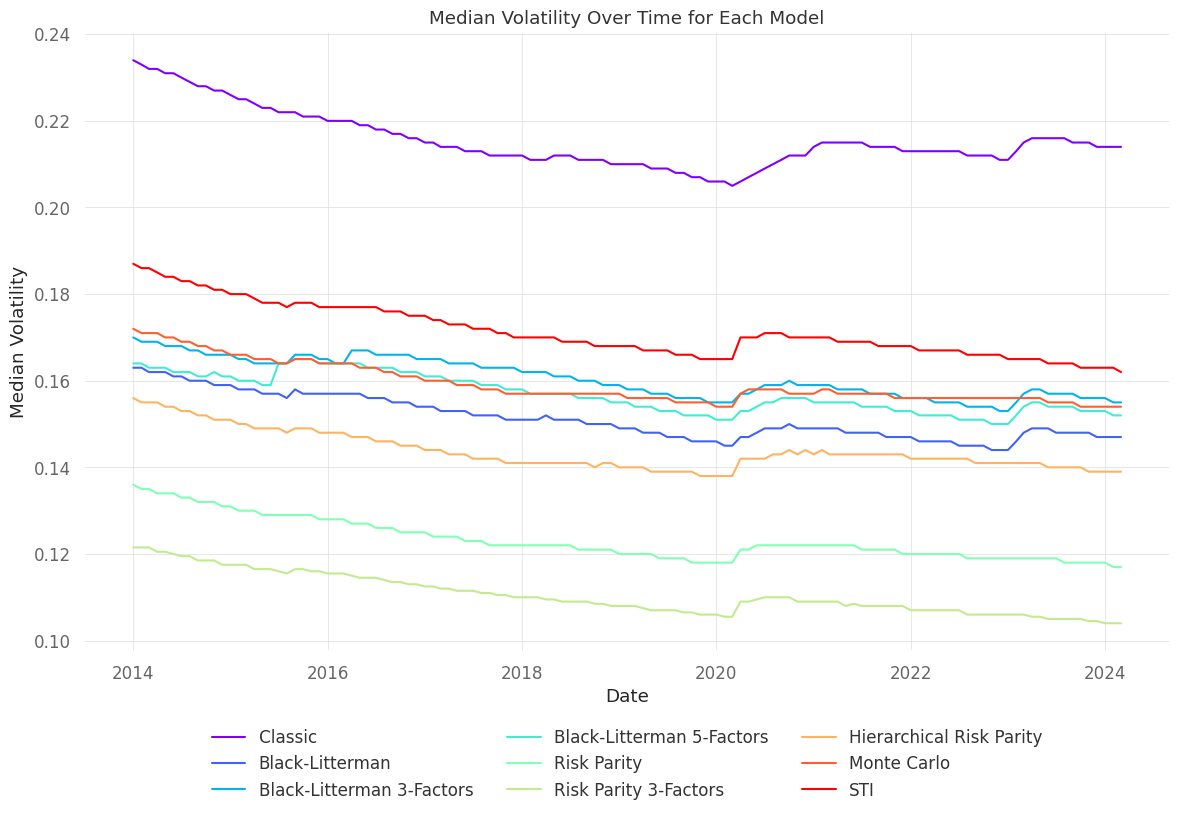

In [20]:
def plot_median_values(metrics_df, group_by_column, measure_types):
    """
    Plots median values for different measure types (models or risk measures)
    across given ratio types.

    :param metrics_df: DataFrame containing the metrics data.
    :param group_by_column: Column name to group by ('Model' or 'RiskMeasure').
    :param measure_types: List of measure types to plot (models or risk measures).
    """
    ratio_types = ["Sharpe Ratio", "Sortino Ratio", "Calmar Ratio", "Volatility"]
    for ratio in ratio_types:
        plt.figure(figsize=(12, 8))
        colors = cm.rainbow(np.linspace(0, 1, len(measure_types)))
        for measure, color in zip(measure_types, colors):
            if group_by_column == "Model":
                # Filter data for the current model and ratio
                data = metrics_df[metrics_df["Model"] == measure]
            else:
                # Group data by 'RiskMeasure' and 'Date', then unstack
                data = (
                    metrics_df[metrics_df["RiskMeasure"] == measure]
                    .groupby(["Date"])[ratio]
                    .median()
                    .reset_index()
                )

            # Calculate median values
            median_values = data.groupby("Date")[ratio].median()
            median_values = median_values.loc["2014":]  # Adjust as needed

            plt.plot(median_values.index, median_values, label=measure, color=color)

        plt.title(f"Median {ratio} Over Time for Each {group_by_column}")
        plt.xlabel("Date")
        plt.ylabel(f"Median {ratio}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.legend(
            bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=3, frameon=False
        )
        plt.show()


# Example usage for models
plot_median_values(
    monthly_cumulative_metrics, "Model", monthly_cumulative_metrics["Model"].unique()
)

In [119]:
metrics = ["Sharpe Ratio", "Volatility", "Calmar Ratio", "Sortino Ratio"]
model_medians_end = monthly_cumulative_metrics.groupby("Model")[metrics]
print(monthly_cumulative_metrics)

            Date                                  Model_RiskMeasure  \
0     2003-02-01                         Classic_Standard Deviation   
1     2003-02-01                    Classic_Mean Absolute Deviation   
2     2003-02-01                    Classic_Semi Standard Deviation   
3     2003-02-01                 Classic_First Lower Partial Moment   
4     2003-02-01                Classic_Second Lower Partial Moment   
...          ...                                                ...   
21585 2024-03-01  Hierarchical Risk Parity_Conditional Drawdown ...   
21586 2024-03-01  Hierarchical Risk Parity_Entropic Drawdown at ...   
21587 2024-03-01               Hierarchical Risk Parity_Ulcer Index   
21588 2024-03-01                     Monte Carlo_Standard Deviation   
21589 2024-03-01                             STI_Standard Deviation   

       Sharpe Ratio  Volatility  Calmar Ratio  Sortino Ratio  \
0             1.400       0.187         5.753          2.313   
1             0.959

In [26]:
metrics = ["Sharpe Ratio", "Sortino Ratio", "Calmar Ratio", "Volatility"]
ascending_flags = {
    "Sharpe Ratio": False,
    "Volatility": True,
    "Calmar Ratio": False,
    "Sortino Ratio": False,
}

model_medians_end = (
    monthly_cumulative_metrics.groupby("Model")[metrics].median().round(3)
)

for metric in metrics:
    model_medians_end[f"{metric}_Ranking"] = model_medians_end[metric].rank(
        ascending=ascending_flags[metric]
    )

    print(f"Rankings and Median Values for {metric}:")
    print(
        model_medians_end[[metric, f"{metric}_Ranking"]]
        .sort_values(by=f"{metric}_Ranking")
        .to_string(),
        "\n",
    )
    model_medians_end[[metric, f"{metric}_Ranking"]].sort_values(
        by=f"{metric}_Ranking"
    ).to_csv(f"../data/backtest/validation/model_{metric}_rankings_Y21.csv")

Rankings and Median Values for Sharpe Ratio:
                           Sharpe Ratio  Sharpe Ratio_Ranking
Model                                                        
Risk Parity 3-Factors             1.006                   1.0
Risk Parity                       0.754                   2.0
Hierarchical Risk Parity          0.603                   3.0
Black-Litterman 3-Factors         0.562                   4.0
Black-Litterman                   0.536                   5.0
Black-Litterman 5-Factors         0.521                   6.0
STI                               0.507                   7.0
Monte Carlo                       0.506                   8.0
Classic                           0.373                   9.0 

Rankings and Median Values for Sortino Ratio:
                           Sortino Ratio  Sortino Ratio_Ranking
Model                                                          
Risk Parity 3-Factors              1.408                    1.0
Risk Parity                      

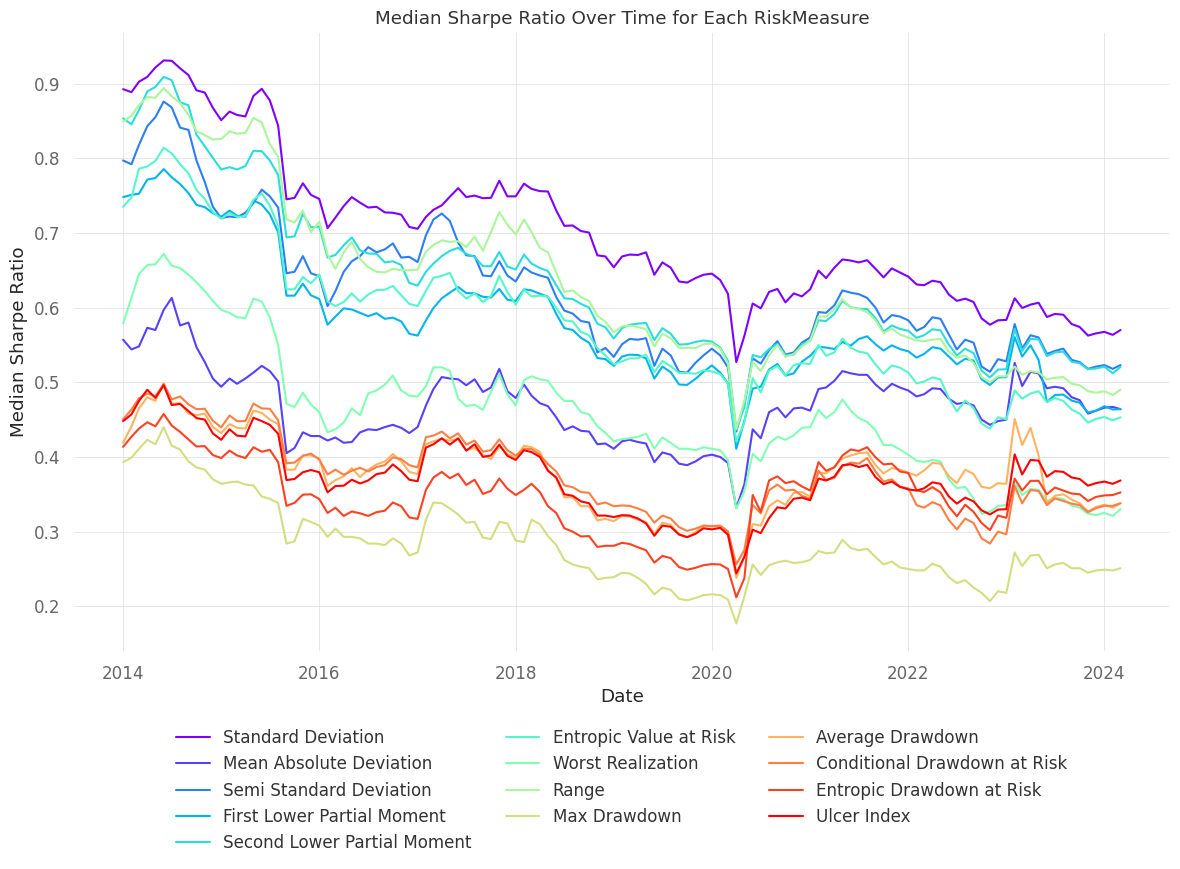

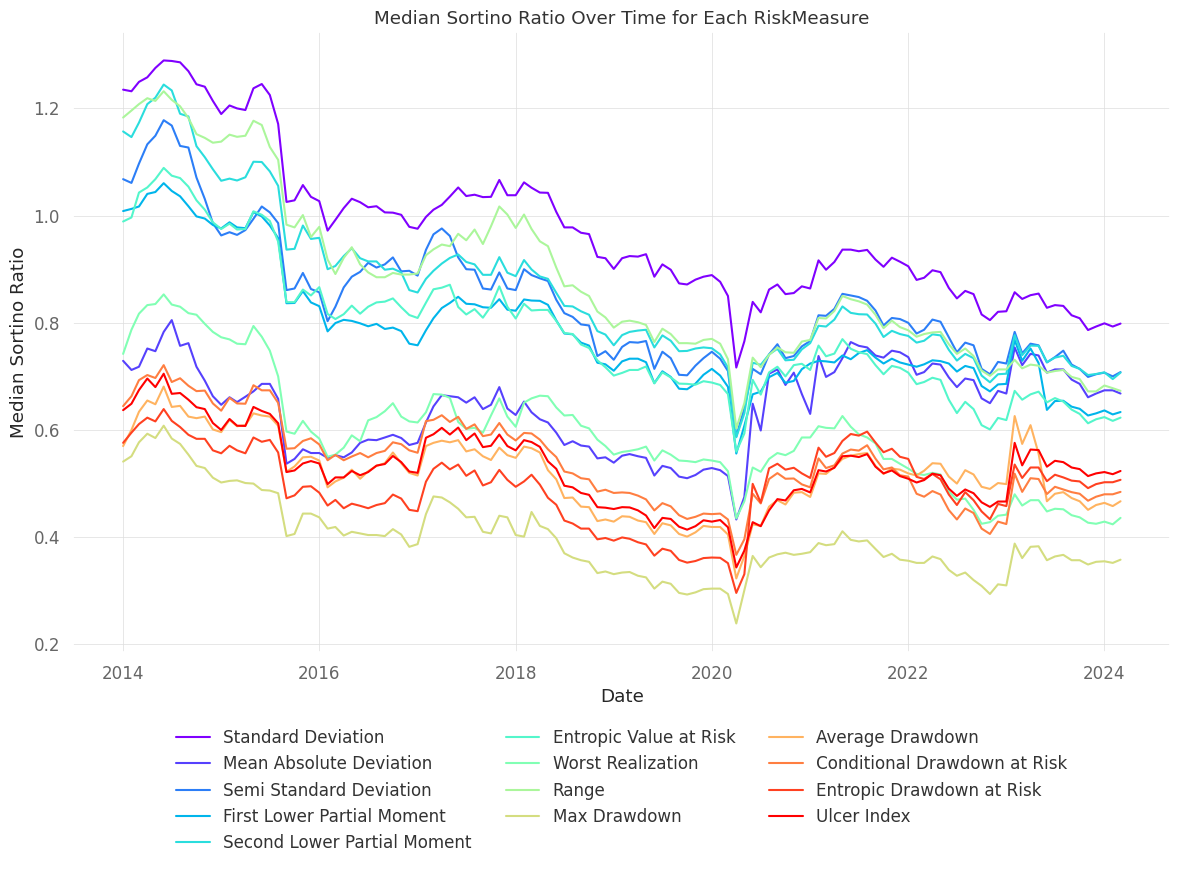

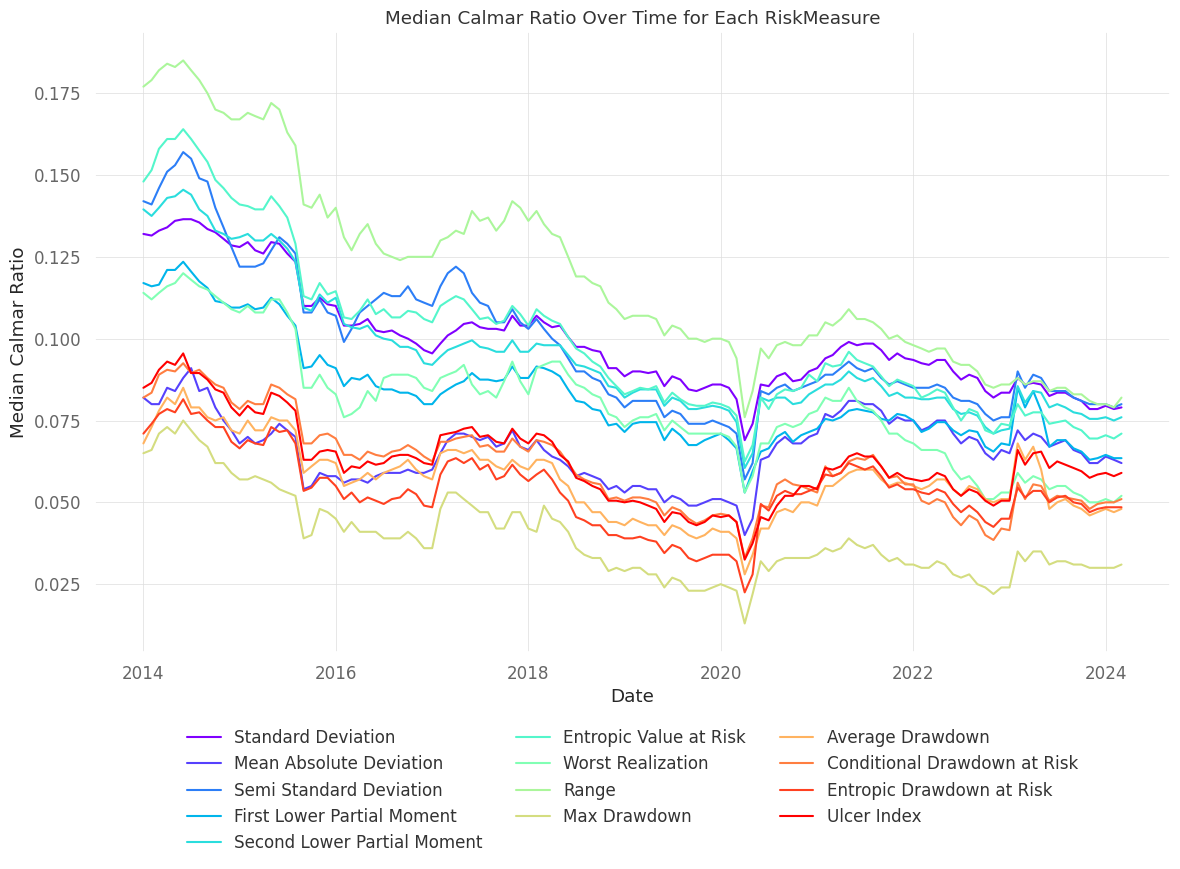

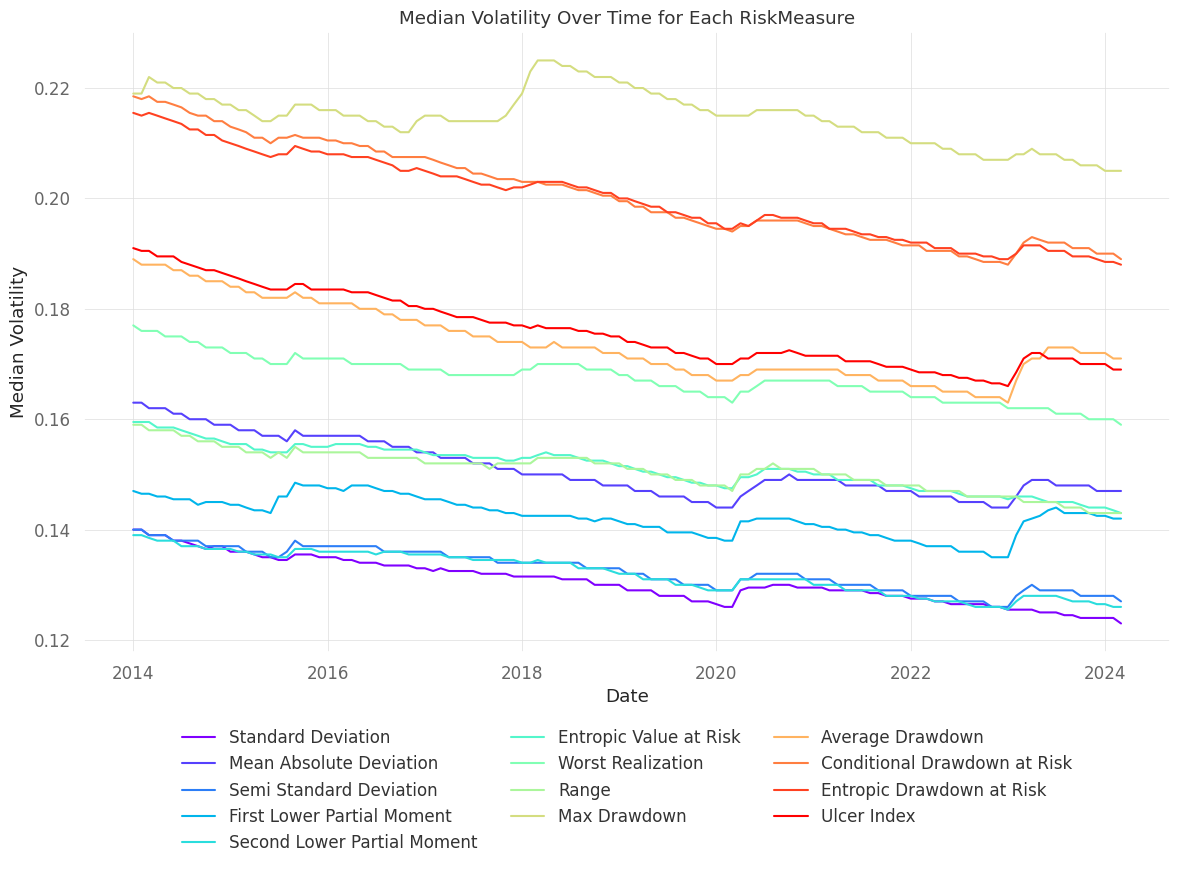

In [23]:
plot_median_values(
    monthly_cumulative_metrics,
    "RiskMeasure",
    monthly_cumulative_metrics["RiskMeasure"].unique(),
)

In [41]:
monthly_cumulative_metrics

Date                                  Model_RiskMeasure  \
0     2003-02-01                         Classic_Standard Deviation   
1     2003-02-01                    Classic_Mean Absolute Deviation   
2     2003-02-01                    Classic_Semi Standard Deviation   
3     2003-02-01                 Classic_First Lower Partial Moment   
4     2003-02-01                Classic_Second Lower Partial Moment   
...          ...                                                ...   
21670 2024-04-01  Hierarchical Risk Parity_Conditional Drawdown ...   
21671 2024-04-01  Hierarchical Risk Parity_Entropic Drawdown at ...   
21672 2024-04-01               Hierarchical Risk Parity_Ulcer Index   
21673 2024-04-01                     Monte Carlo_Standard Deviation   
21674 2024-04-01                             STI_Standard Deviation   

       Sharpe Ratio  Volatility  Calmar Ratio  Sortino Ratio  \
0             1.400       0.187         5.753          2.313   
1             0.959       0.201         4.077          1.561   
2             1.393       0.186         5.487          2.277   
3             0.977       0.200         4.091          1.590   
4             1.408       0.186         5.532          2.301   
...             ...         ...           ...            ...   
21670         0.473       0.142         0.061          0.649   
21671         0.465       0.141         0.059          0.636   
21672         0.507       0.143         0.068          0.693   
21673         0.307       0.153         0.038          0.428   
21674         0.337       0.162         0.047          0.474   

                          Model                   RiskMeasure  
0                       Classic            Standard Deviation  
1                       Classic       Mean Absolute Deviation  
2                       Classic       Semi Standard Deviation  
3                       Classic    First Lower Partial Moment  
4                       Classic   Second Lower Partial Moment  
...                         ...                           ...  
21670  Hierarchical Risk Parity  Conditional Drawdown at Risk  
21671  Hierarchical Risk Parity     Entropic Drawdown at Risk  
21672  Hierarchical Risk Parity                   Ulcer Index  
21673               Monte Carlo            Standard Deviation  
21674                       STI            Standard Deviation  

[21675 rows x 8 columns]

In [31]:
metrics = ["Sharpe Ratio", "Sortino Ratio", "Calmar Ratio", "Volatility"]
ascending_flags = {
    "Sharpe Ratio": False,
    "Volatility": True,
    "Calmar Ratio": False,
    "Sortino Ratio": False,
}

# Exclude the STI model
monthly_cumulative_metrics_temp = monthly_cumulative_metrics[
    monthly_cumulative_metrics["Model"] != "STI"
]
# Calculate the median values for each model at the end of the period
model_medians_end = (
    monthly_cumulative_metrics_temp.groupby("RiskMeasure")[metrics].median().round(3)
)

# Adjust rankings for each metric and print them separately
for metric in metrics:
    # Rank models based on the current metric, considering the appropriate ascending flag
    model_medians_end[f"{metric}_Ranking"] = model_medians_end[metric].rank(
        ascending=ascending_flags[metric]
    )

    # Print the median values and rankings for the current metric
    print(f"Rankings and Median Values for {metric}:")
    print(
        model_medians_end[[metric, f"{metric}_Ranking"]]
        .sort_values(by=f"{metric}_Ranking")
        .to_string(),
        "\n",
    )
    df = model_medians_end[[metric, f"{metric}_Ranking"]].sort_values(
        by=f"{metric}_Ranking"
    )
    df.columns = [metric, "Ranking"]
    df["Risk Measure"] = df.index
    df.reset_index(drop=True, inplace=True)
    df = df[["Ranking", "Risk Measure", metric]]
    df["Ranking"] = df["Ranking"].astype(int)
    df.to_csv(f"../data/backtest/validation/rm_{metric}_rankings_Y21.csv", index=False)

Rankings and Median Values for Sharpe Ratio:
                              Sharpe Ratio  Sharpe Ratio_Ranking
RiskMeasure                                                     
Standard Deviation                   0.772                   1.0
Semi Standard Deviation              0.734                   2.0
Range                                0.696                   3.0
Second Lower Partial Moment          0.686                   4.0
Entropic Value at Risk               0.631                   5.0
First Lower Partial Moment           0.600                   6.0
Mean Absolute Deviation              0.550                   7.0
Worst Realization                    0.468                   8.0
Conditional Drawdown at Risk         0.453                   9.0
Ulcer Index                          0.443                  10.0
Entropic Drawdown at Risk            0.431                  11.0
Average Drawdown                     0.390                  12.0
Max Drawdown                         0.352   

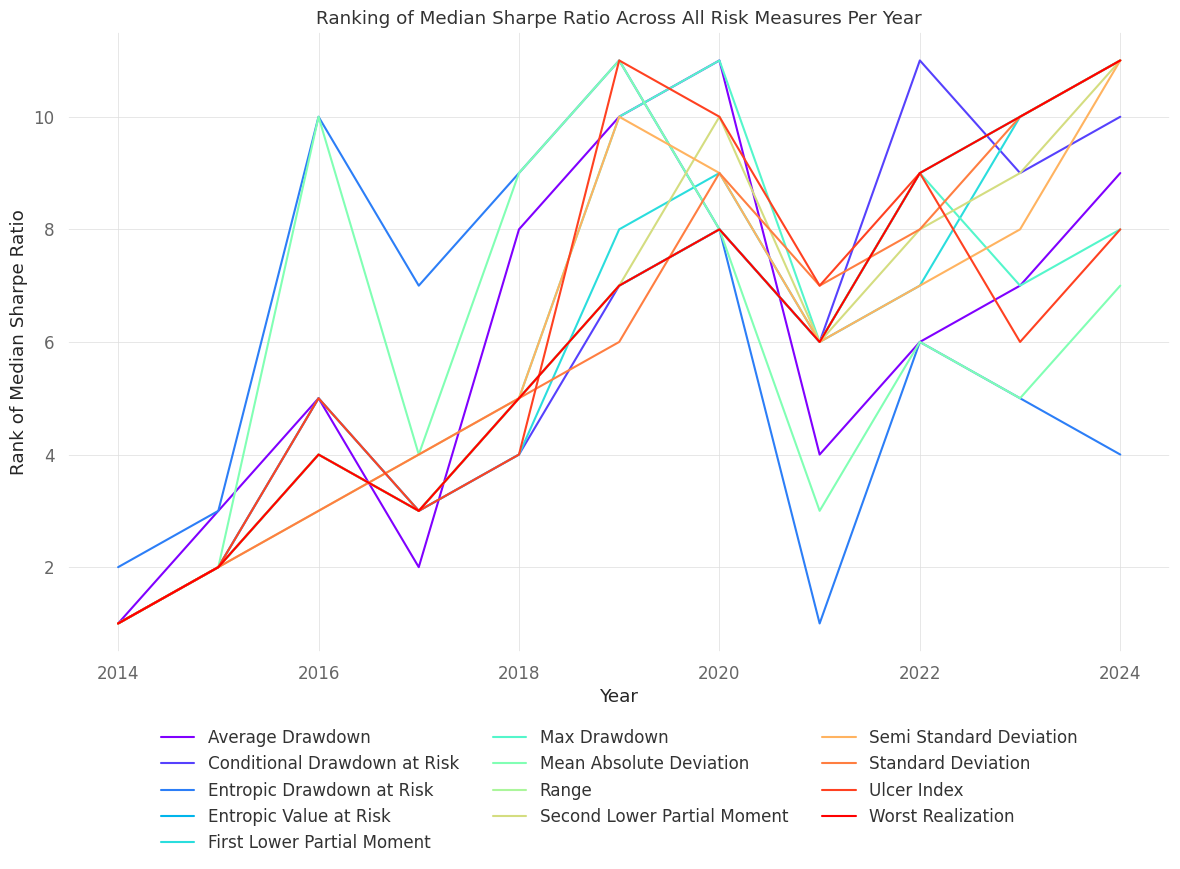

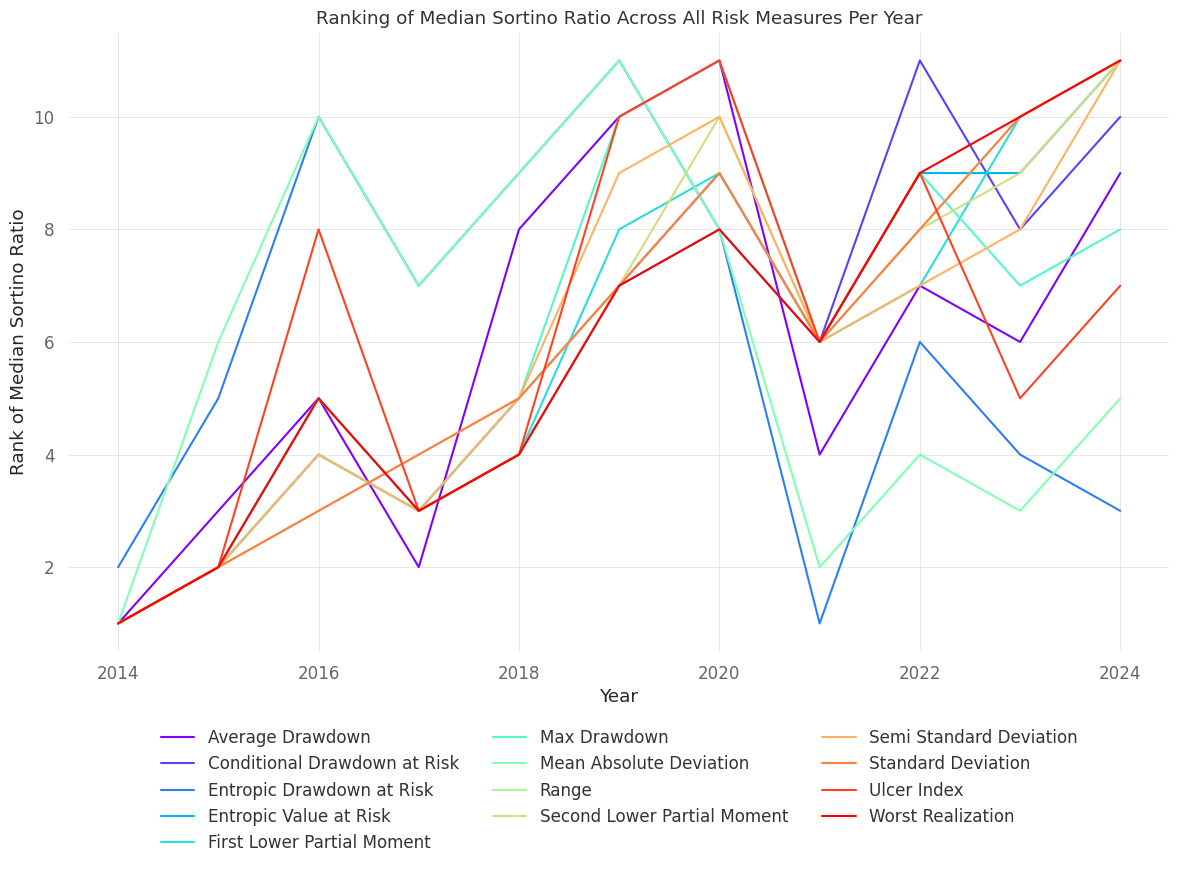

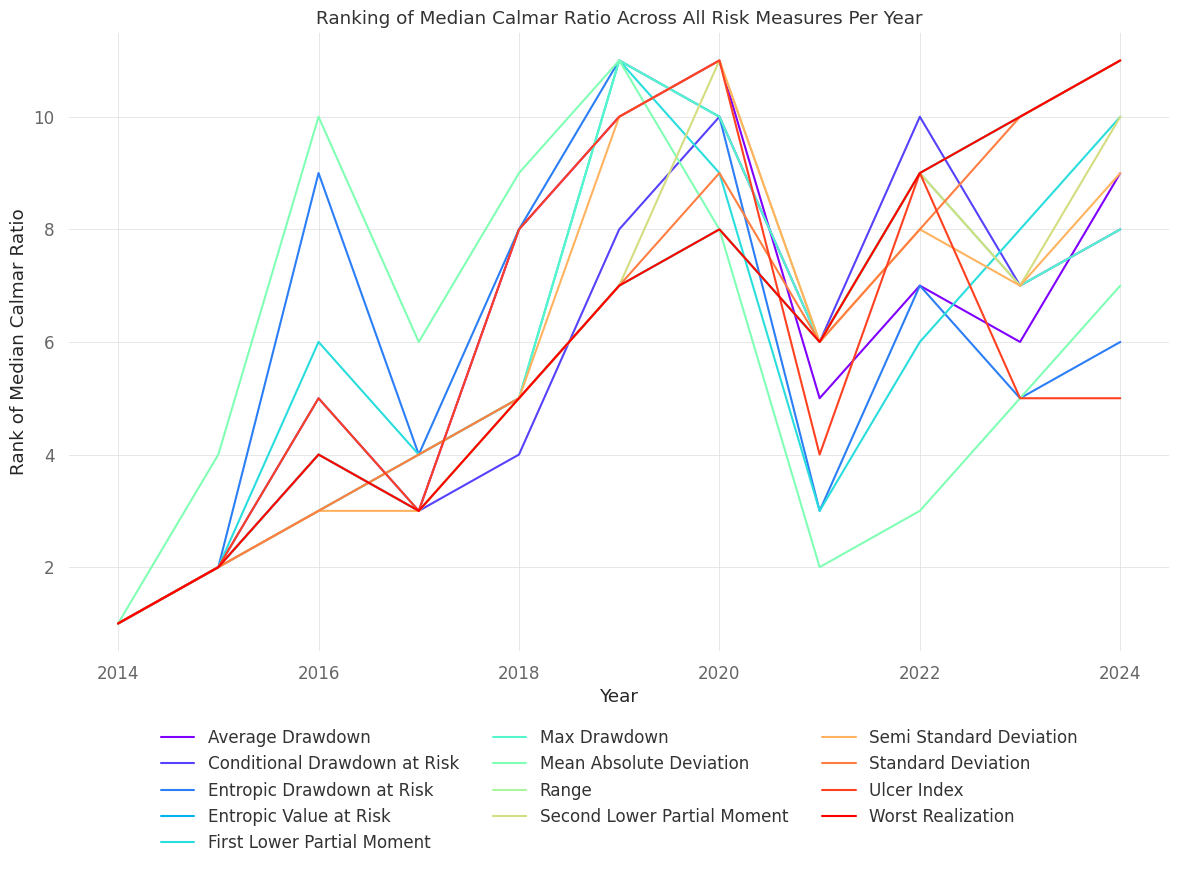

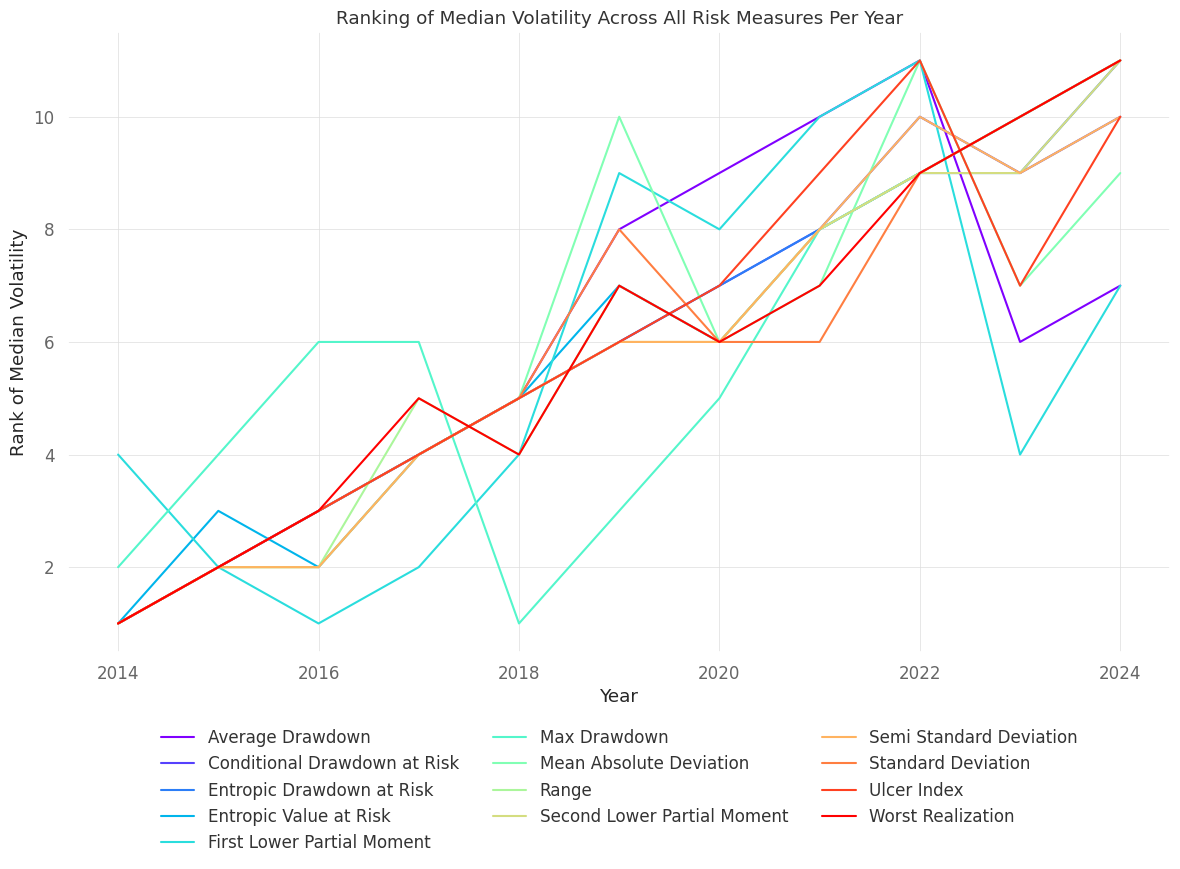

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm


def plot_median_rankings_for_risk_measures(metrics_df):
    risk_measures = ["Sharpe Ratio", "Sortino Ratio", "Calmar Ratio", "Volatility"]
    metrics_df = metrics_df.loc[metrics_df["Date"] >= "2014"]
    metrics_df["Year"] = pd.to_datetime(metrics_df["Date"]).dt.year

    for measure in risk_measures:
        plt.figure(figsize=(12, 8))

        # Group by Year and RiskMeasure, then calculate median values
        grouped_data = (
            metrics_df.groupby(["Year", "RiskMeasure"])[measure].median().unstack()
        )

        # Rank the median values within each year
        rankings = grouped_data.rank(
            method="min", ascending=False
        )  # Use ascending=True for inverse rankings

        risk_measure_types = rankings.columns
        colors = cm.rainbow(np.linspace(0, 1, len(risk_measure_types)))

        for risk_measure, color in zip(risk_measure_types, colors):
            plt.plot(
                rankings.index, rankings[risk_measure], label=risk_measure, color=color
            )

        plt.title(f"Ranking of Median {measure} Across All Risk Measures Per Year")
        plt.xlabel("Year")
        plt.ylabel(f"Rank of Median {measure}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Customize legend
        plt.legend(
            bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=3, frameon=False
        )
        plt.show()


# Call the modified plotting function
plot_median_rankings_for_risk_measures(monthly_cumulative_metrics)

In [44]:
import pandas as pd
import vectorbt as vbt
import quantstats as qs

port = vbt.Portfolio.load(
    f"../data/backtest/objects/Risk Parity 3-Factors_Mean Absolute Deviation_B3_P3.pkl"
)

In [45]:
returns_series = port.returns()

returns = pd.read_parquet(
    f"../data/studying_models/output_returns/Classic_Standard Deviation_2022_Q1.parquet"
)

In [46]:
returns_series.head()

Date
2000-01-03    0.0
2000-01-04    0.0
2000-01-05    0.0
2000-01-06    0.0
2000-01-07    0.0
Name: group, dtype: float64

In [47]:
returns = pd.Series(returns.squeeze(), name="group", index=returns.index)
returns.index.name = "Date"
print(returns.head())

Date
2022-01-05   -0.009675
2022-01-06   -0.007526
2022-01-07   -0.009579
2022-01-10    0.001919
2022-01-11   -0.008475
Name: group, dtype: float64


                           Strategy
-------------------------  ----------
Start Period               2022-01-05
End Period                 2022-03-31
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -3.72%
CAGR﹪                     -10.62%

Sharpe                     -0.32
Prob. Sharpe Ratio         37.28%
Smart Sharpe               -0.3
Sortino                    -0.43
Smart Sortino              -0.4
Sortino/√2                 -0.3
Smart Sortino/√2           -0.28
Omega                      0.89

Max Drawdown               -12.72%
Longest DD Days            85
Volatility (ann.)          10.13%
Calmar                     -0.84
Skew                       -0.5
Kurtosis                   1.77

Expected Daily %           -0.06%
Expected Monthly %         -1.25%
Expected Yearly %          -3.72%
Kelly Criterion            -6.0%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.21%
Expected Shortfall (cVaR)  -2.21%

Max Consecutive Win

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2022-01-06  2022-03-08  2022-03-31    85    -12.718572         -12.46475

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


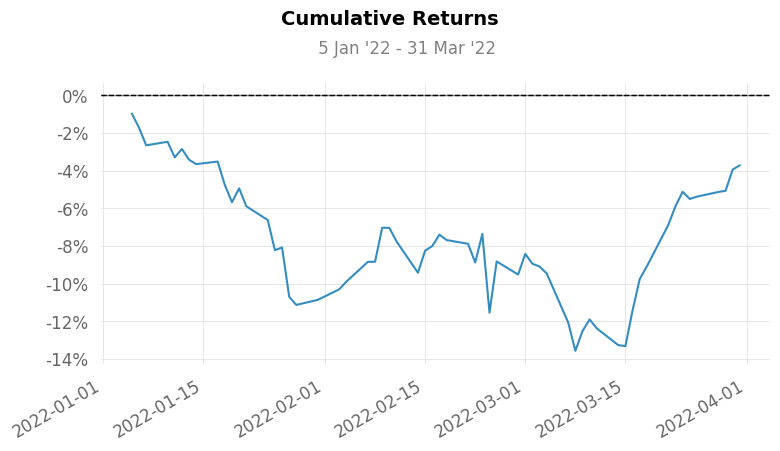

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


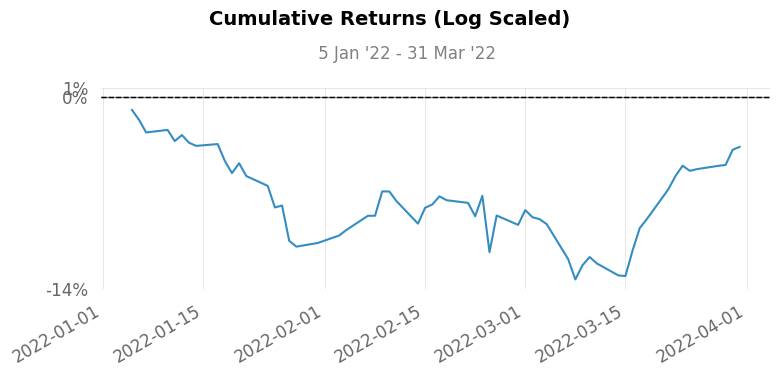

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


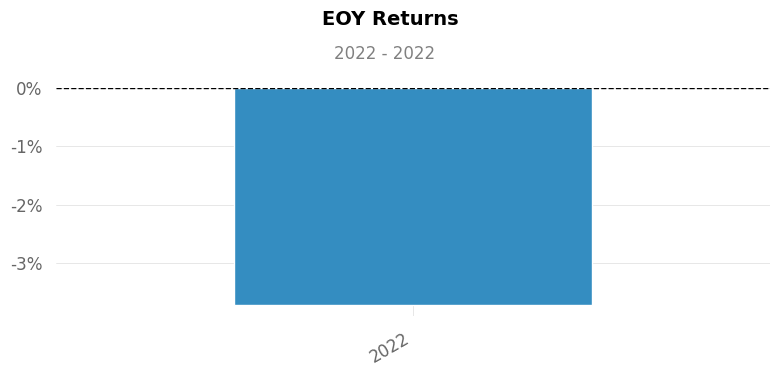

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


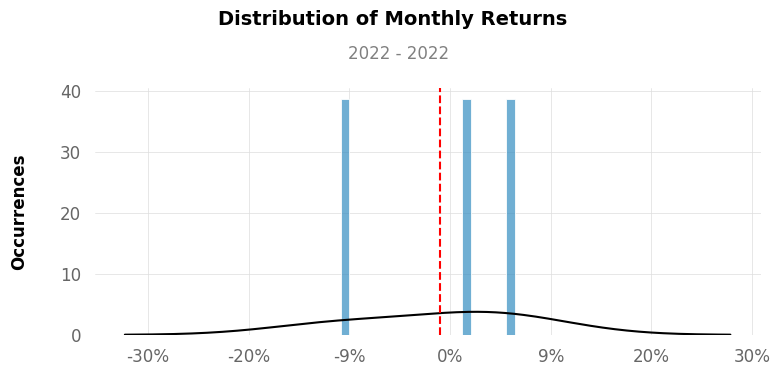

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


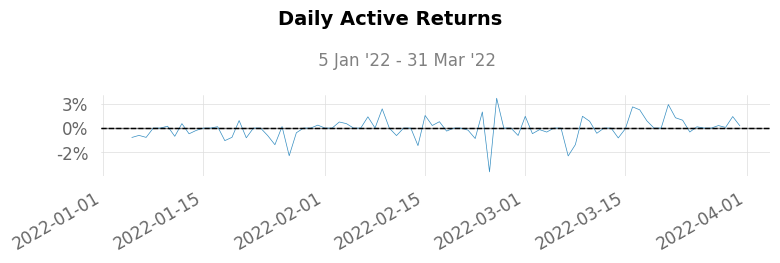

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


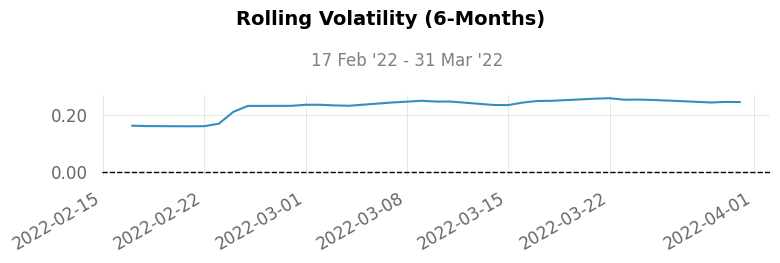

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


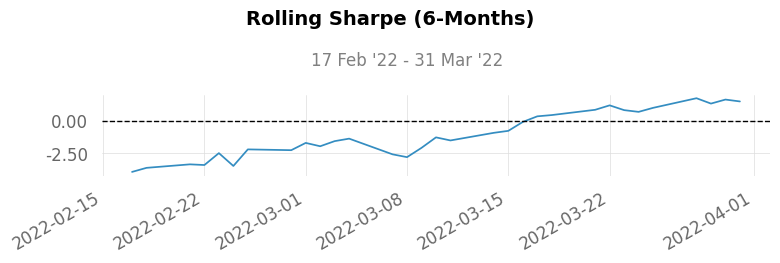

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


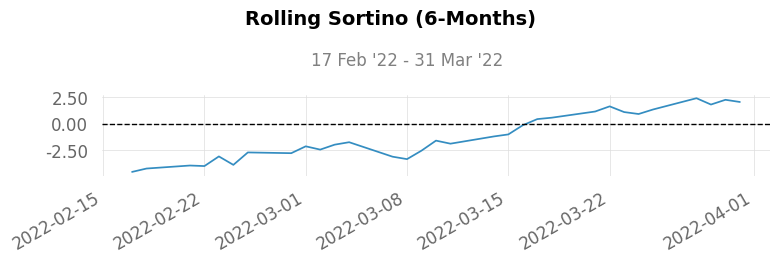

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


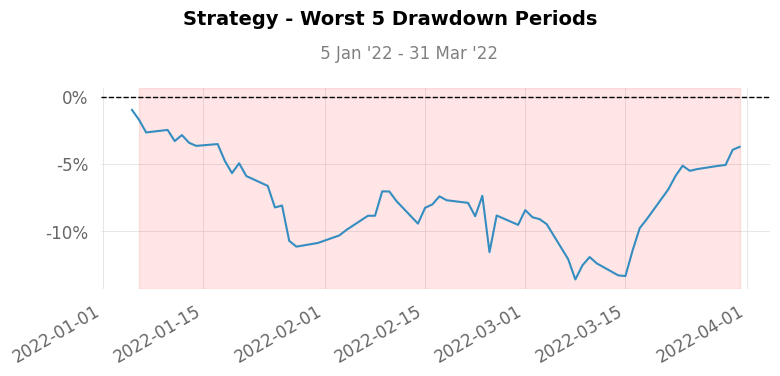

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


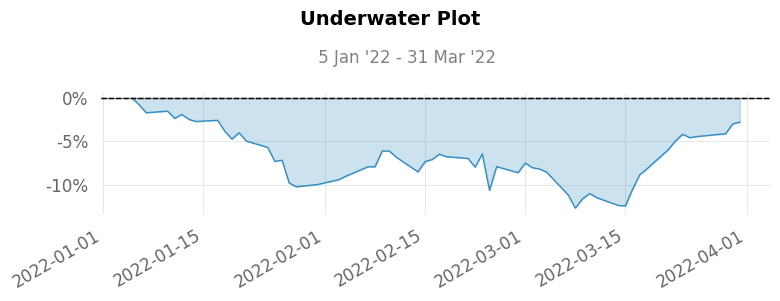

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


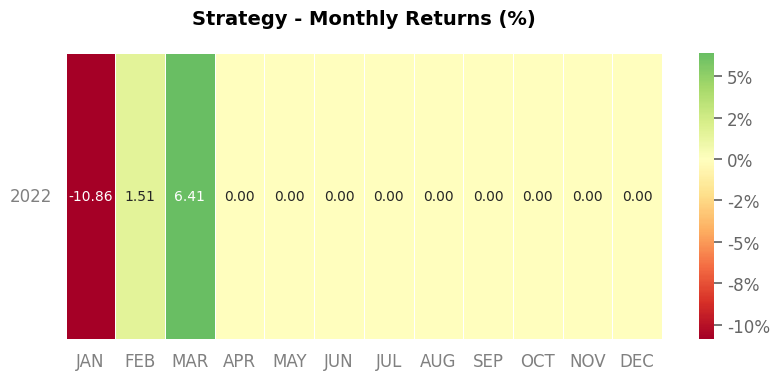

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


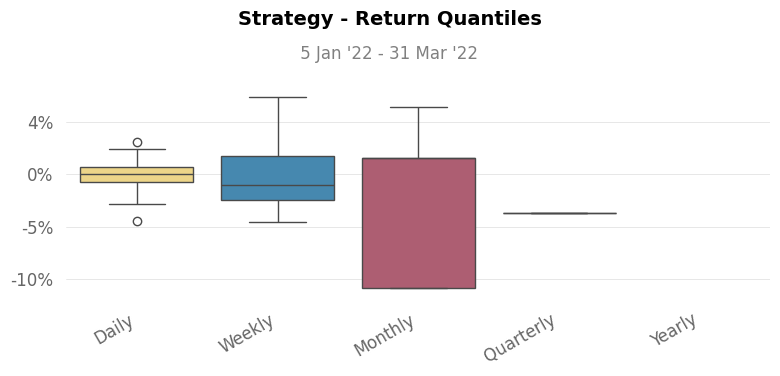

In [48]:
qs.reports.full(returns=returns, periods_per_year=len(returns))